In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

In [30]:
region_info = [
    ("Andorra", "AD", "AND"),
    ("Austria", "AT",  "AUT"),
    ("Albania","AL","ALB"),
    ("Bosnia and Herzegovina", "BA", "BIH"),
    ("Belgium", "BE", "BEL"),
    ("Bulgaria",  "BG", "BGR"),
    ("Switzerland", "CH", "CHE"),
    ("Czech Republic", "CZ", "CZE"),
    ("Germany", "DE", "DEU"),
    ("Denmark", "DK", "DNK"),
    ("Estonia","EE", "EST"),
    ("Spain", "ES", "ESP"),
    ("Finland", "FI", "FIN"),
    ("France", "FR", "FRA"),
    ("United Kingdom", "GB", "GBR"), 
    ("Georgia","GE","GEO"),
    ("Greece", "GR", "GRC"),
    ("Croatia", "HR", "HRV"),
    ("Hungary", "HU", "HUN"),
    ("Ireland", "IE", "IRL"),
    ("Israel", "IL", "ISR"),
    ("Iceland", "IS", "ISL"),
    ("Italy", "IT", "ITA"),
    ("Lithuania","LT","LTU"),
    ("Latvia","LV","LVA"),
    ("Malta","MT","MLT"),
    ("Morocco", "MA", "MAR"),
    ("Mexico","MX", "MEX"),
    ("Malaysia", "MY", "MYS"),
    ("Netherlands", "NL", "NLD"),
    ("Norway","NO","NOR"),
    ("New Zealand","NZ","NZL"),
    ("Poland","PL", "POL"),
    ("Portugal","PT","PRT"),
    ("Romania","RO", "ROU"),
    ("Serbia", "RS", "SRB"),
    ("Sweden", "SE", "SWE"),
    ("Singapore", "SG", "SGP"),
    ("Slovenia", "SI", "SVN"),
    ("Slovakia", "SK", "SVK"),
    ("South Africa", "ZA",  "ZAF"),
]

region_info.sort(key = lambda x: x[0])
region_names = list([x for x, _, _ in region_info])
regions_epi = list([x for _, x, _ in region_info])

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Smoothing
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Albania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Andorra
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Estonia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Iceland
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Latvia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Lithuania
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing New Zealand
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Singapore
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Skipping smoothing Slovakia
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Performing Masking


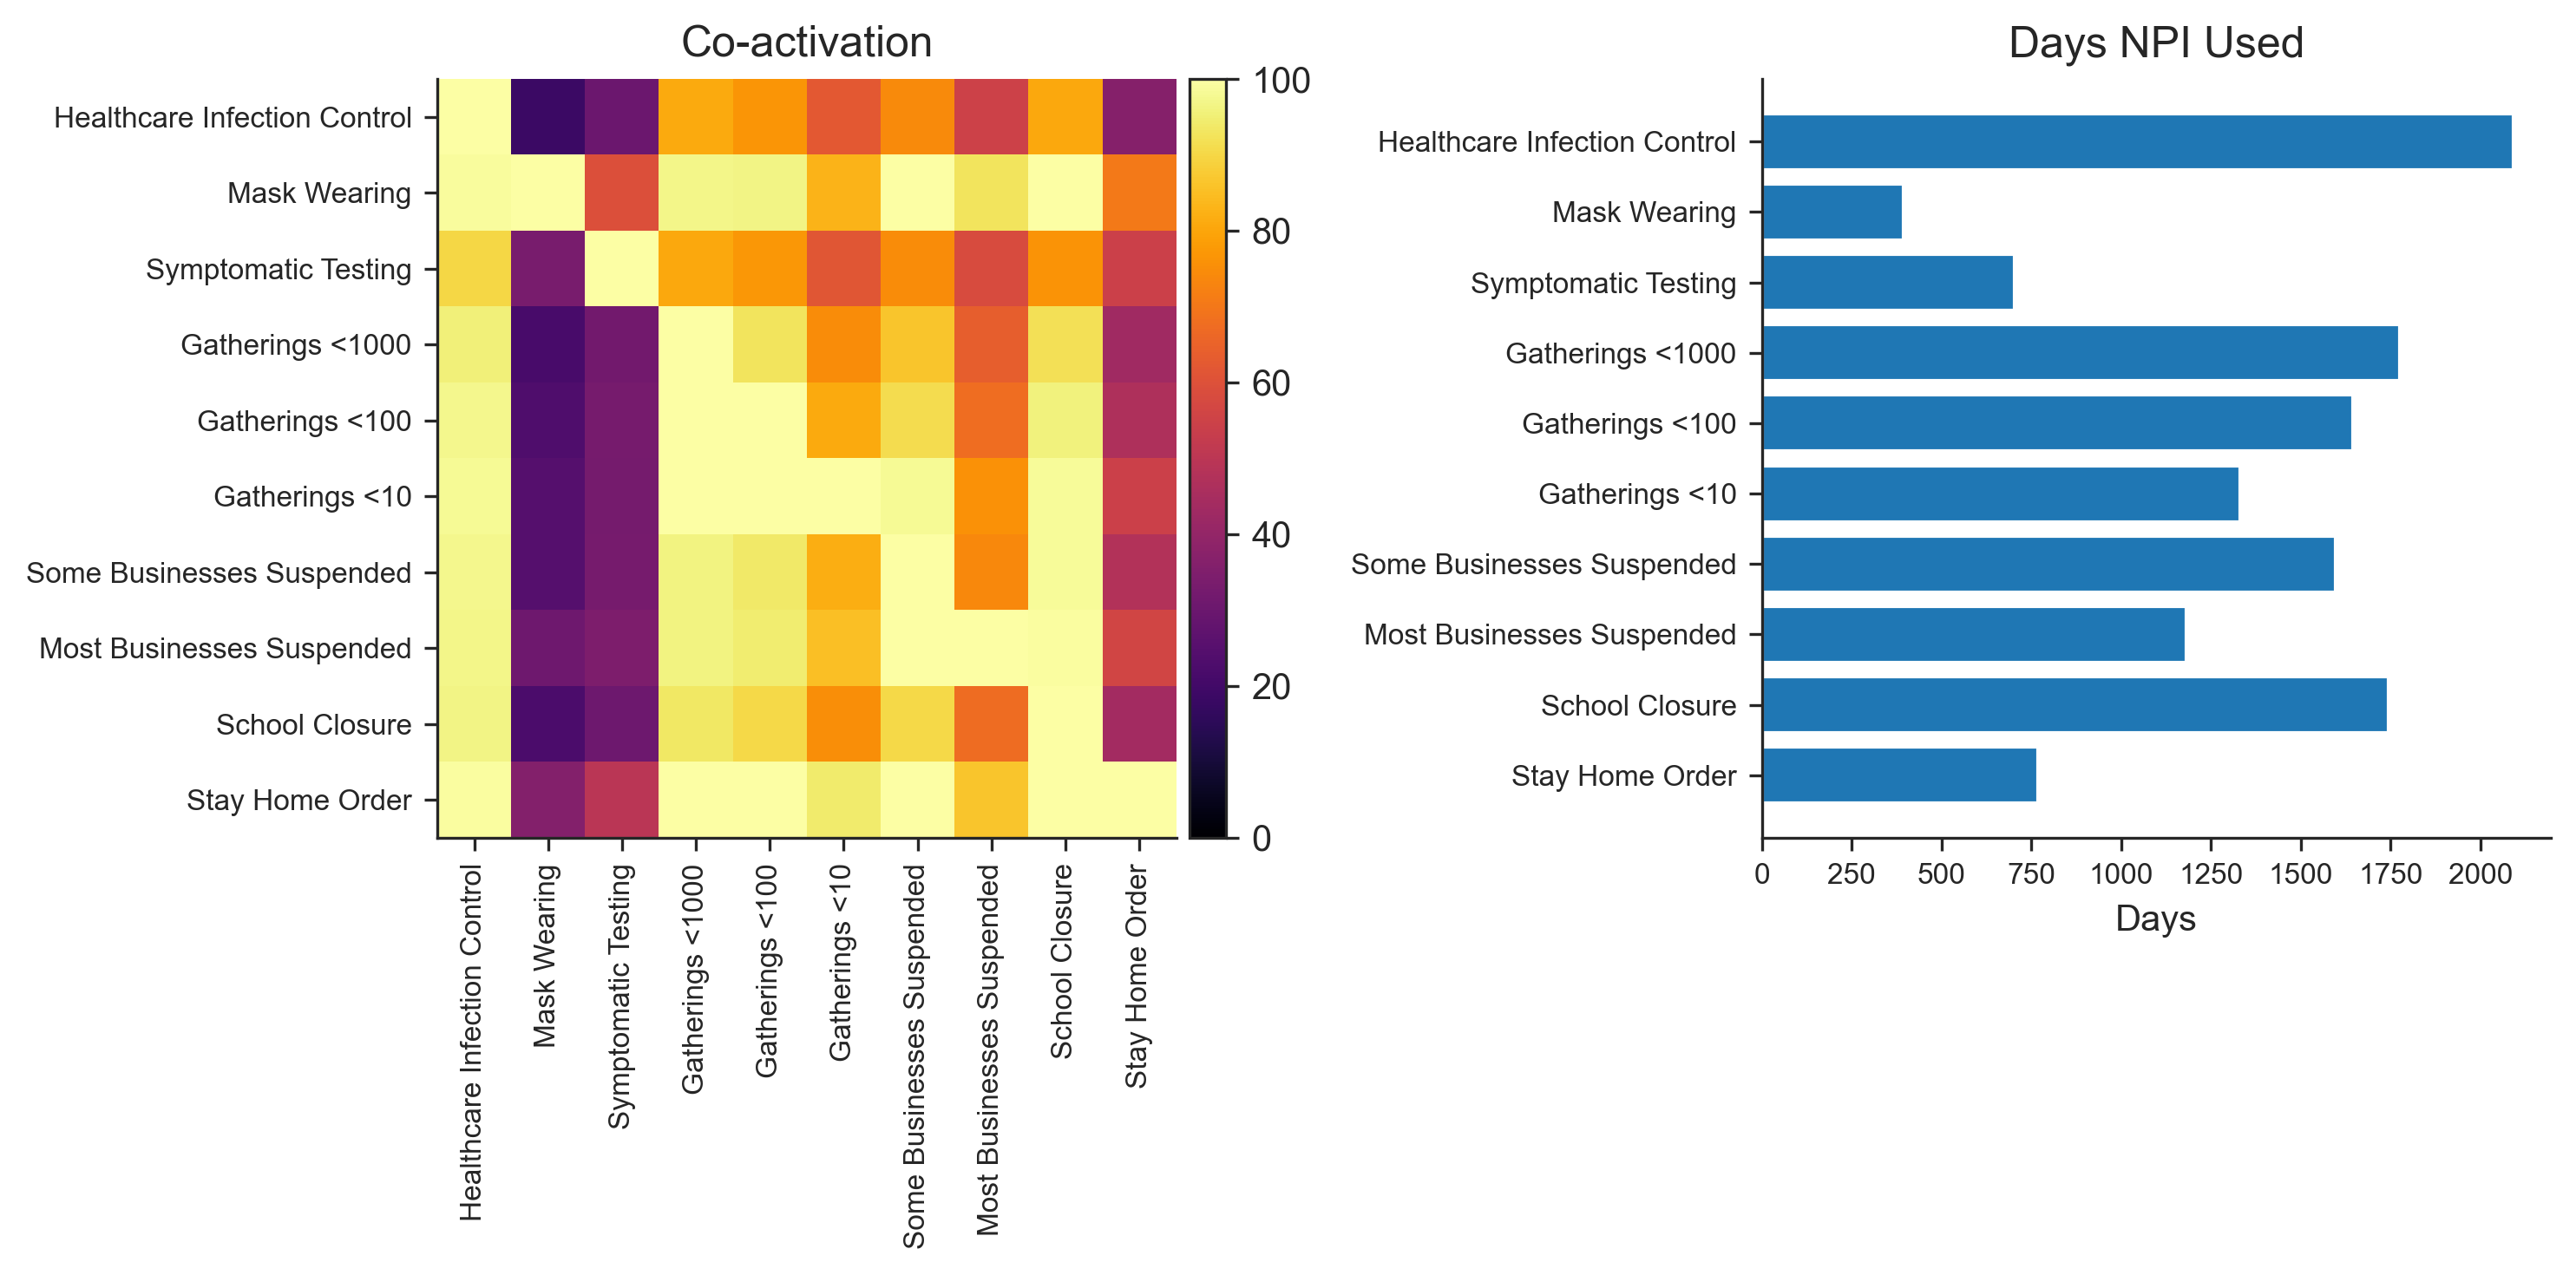

In [31]:
dp = DataPreprocessor()
data = dp.preprocess_data("data_final.csv")

In [32]:
nDs = len(data.Ds)

2020-04-25 00:00:00+00:00
Bosnia and Herzegovina, 57.0
Bulgaria, 55.0
Croatia, 54.0
Estonia, 46.0
Lithuania, 41.0
Malaysia, 98.0
Slovenia, 81.0
South Africa, 86.0


/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-pa

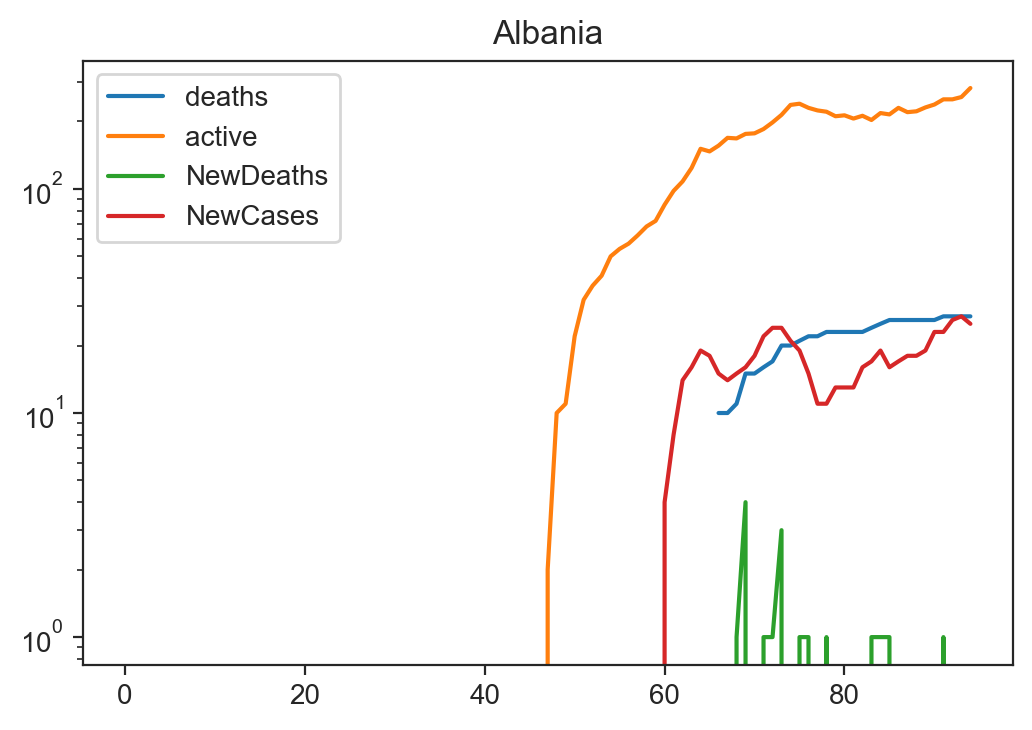

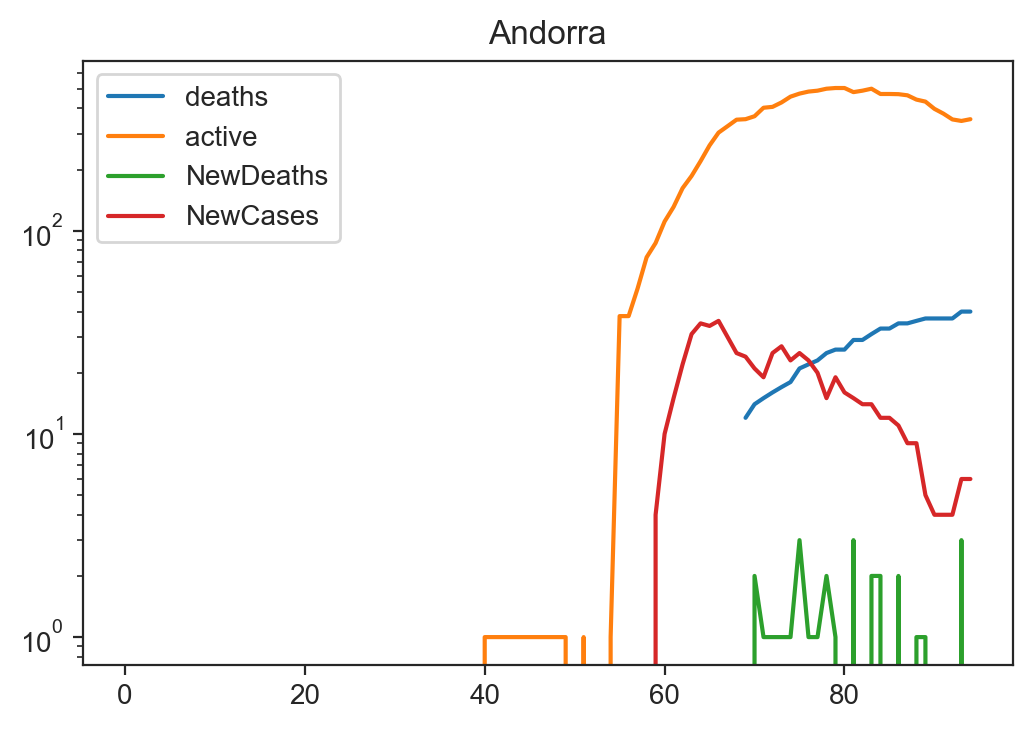

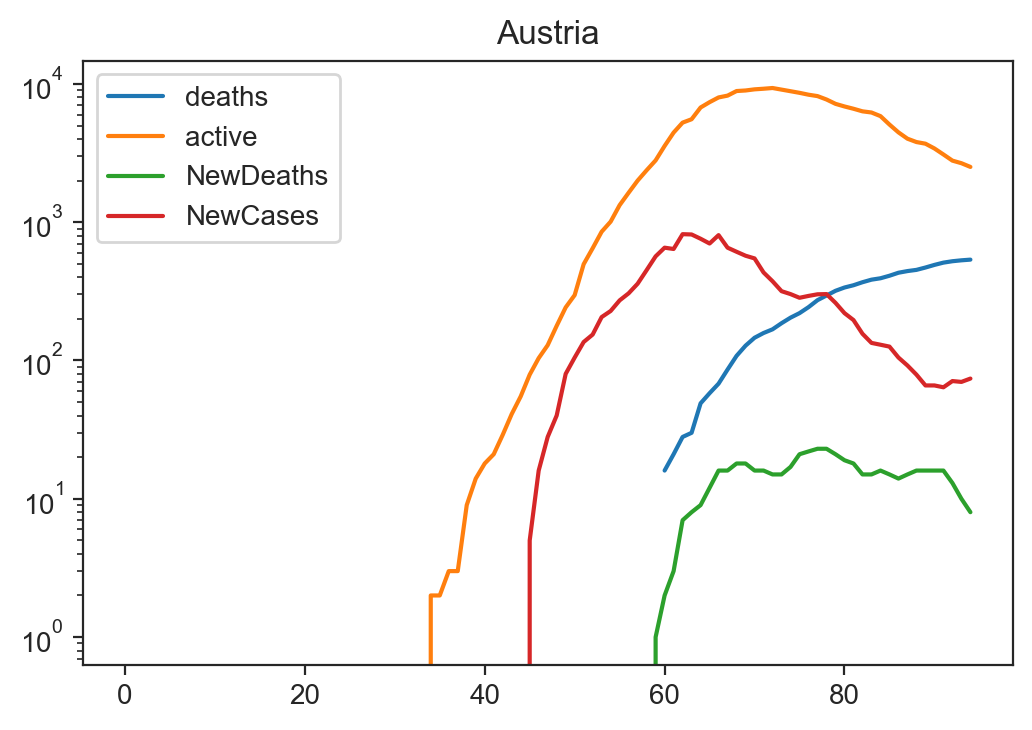

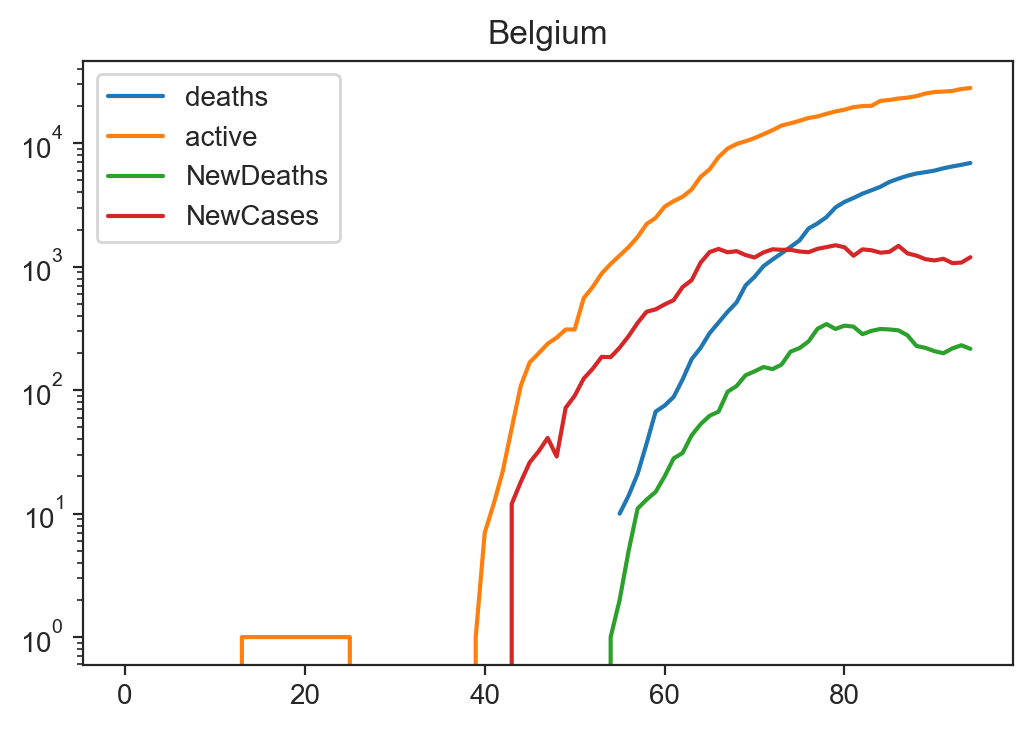

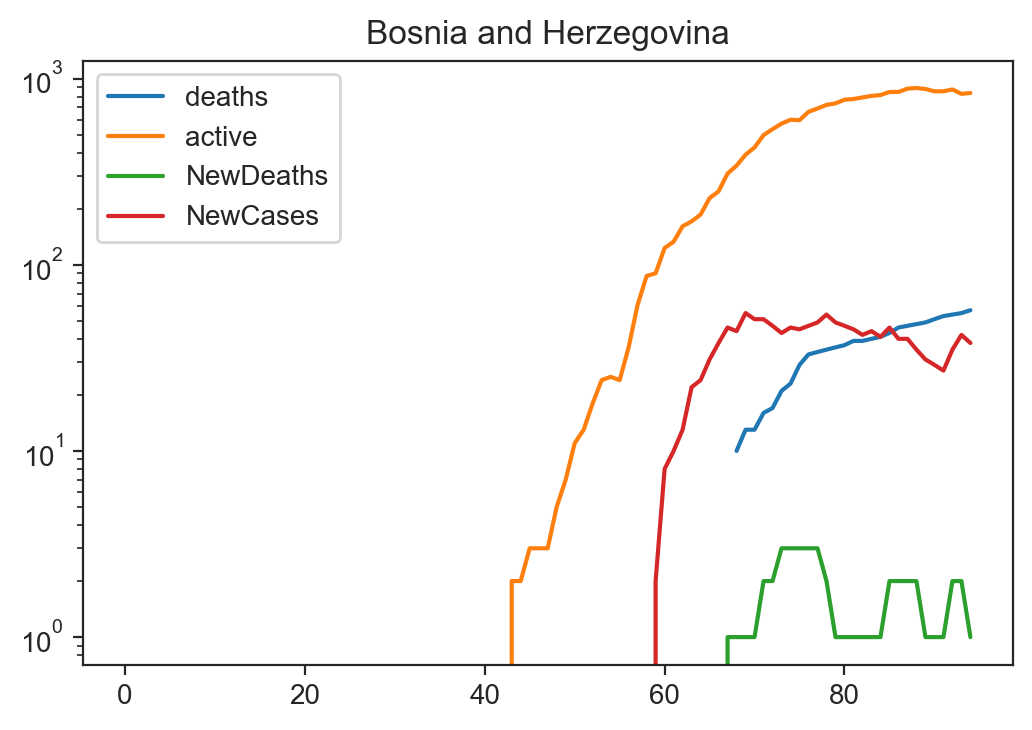

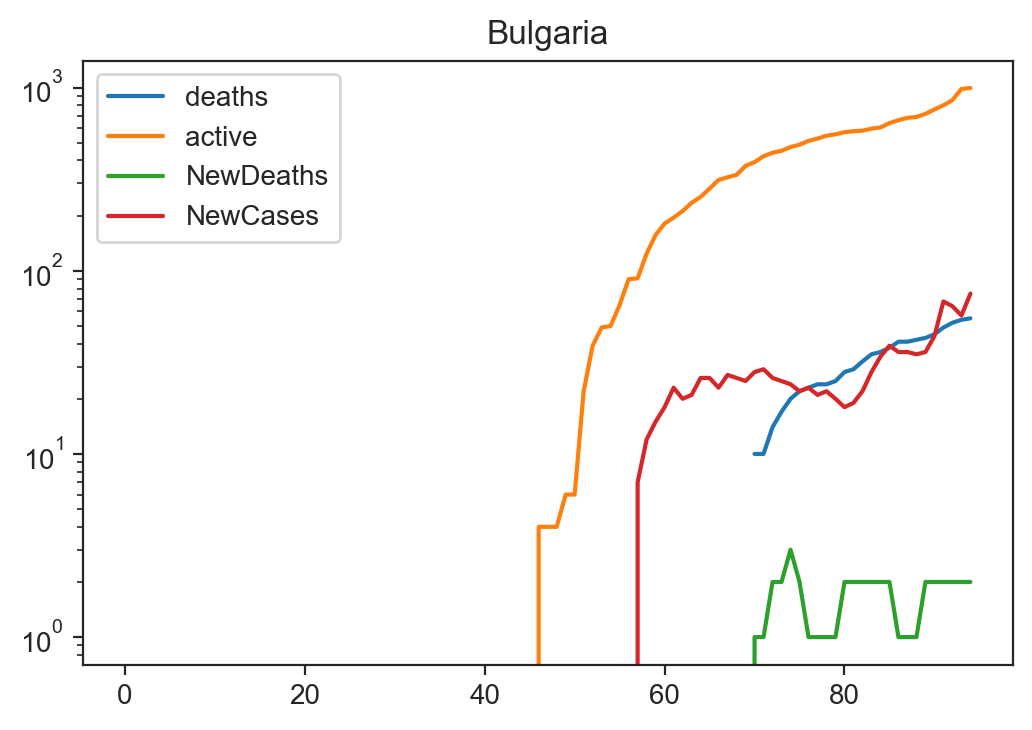

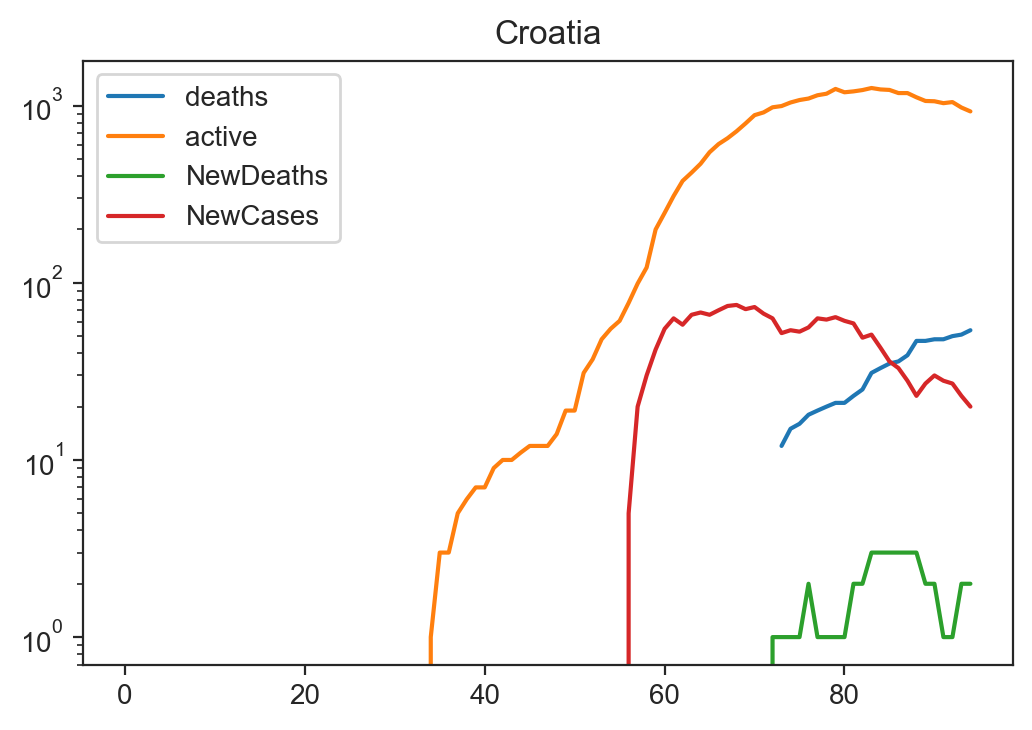

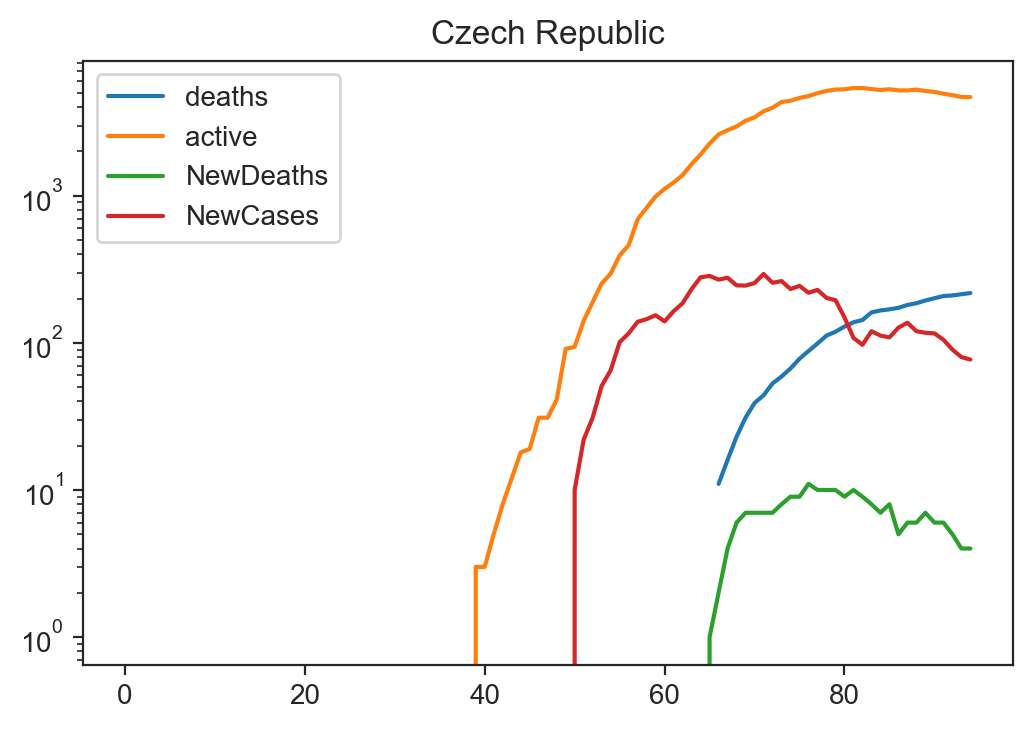

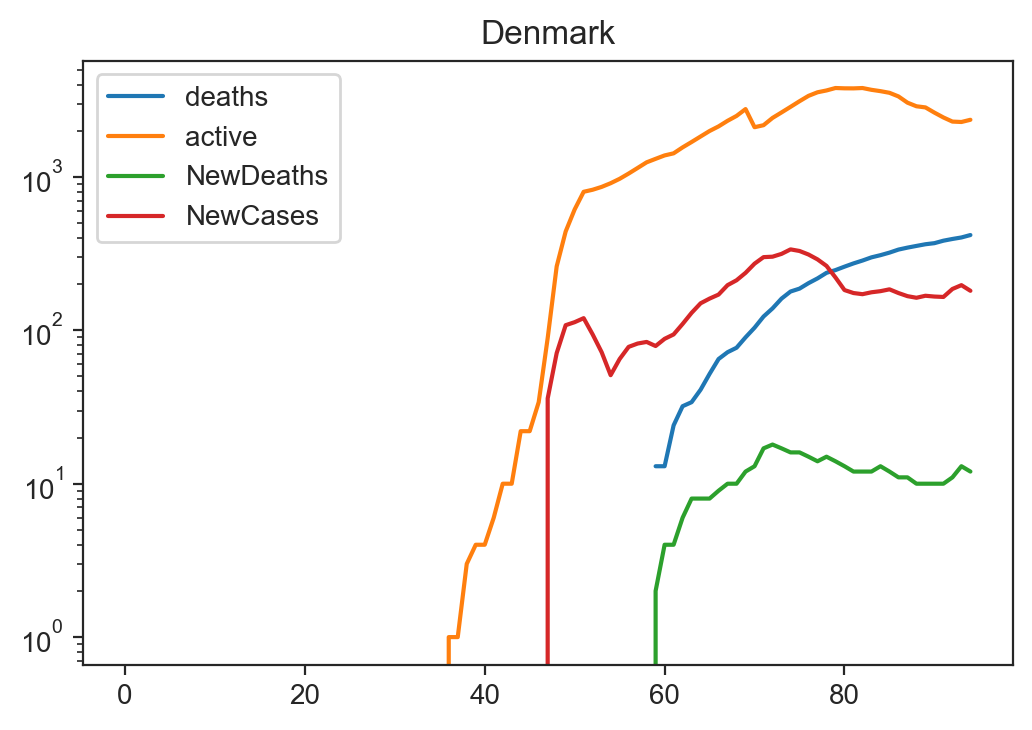

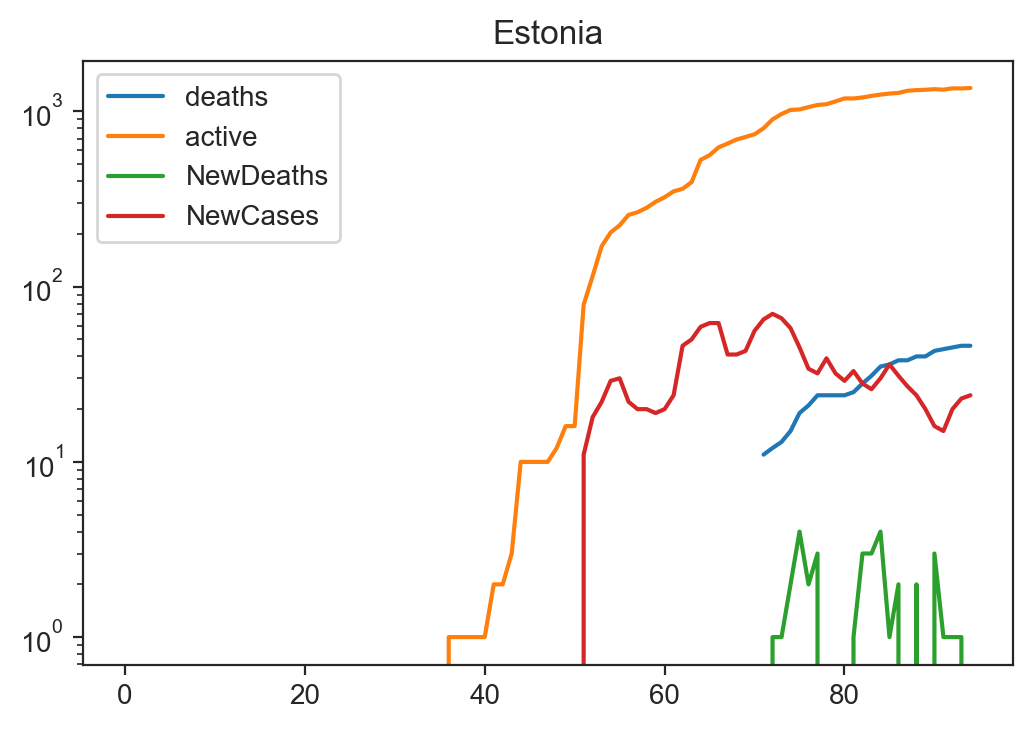

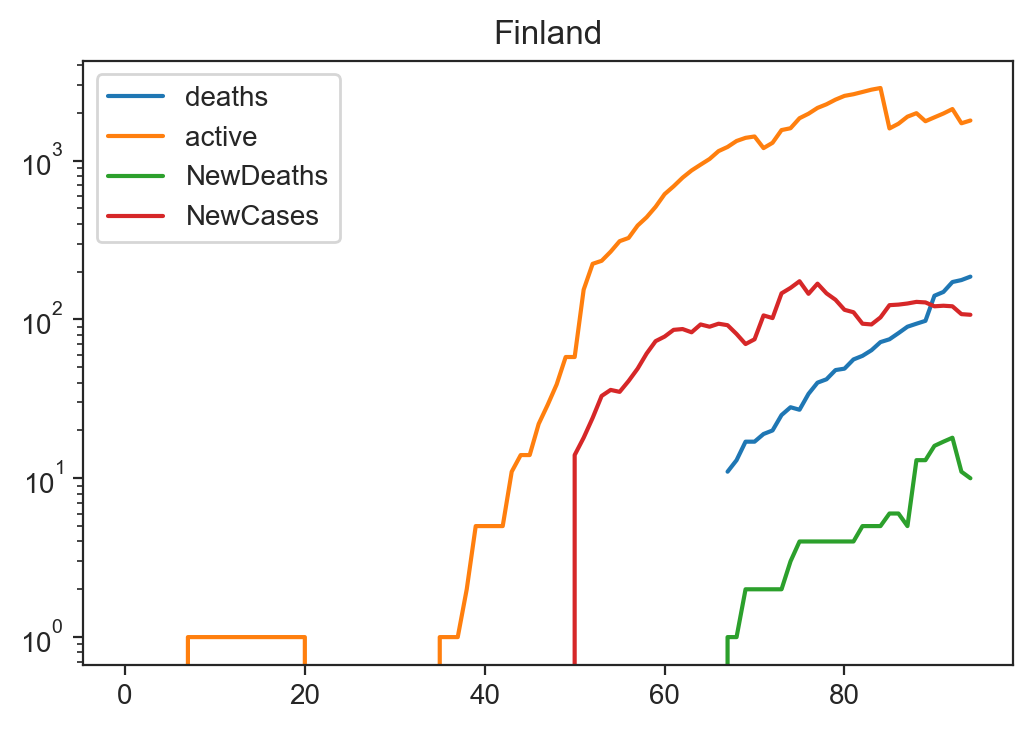

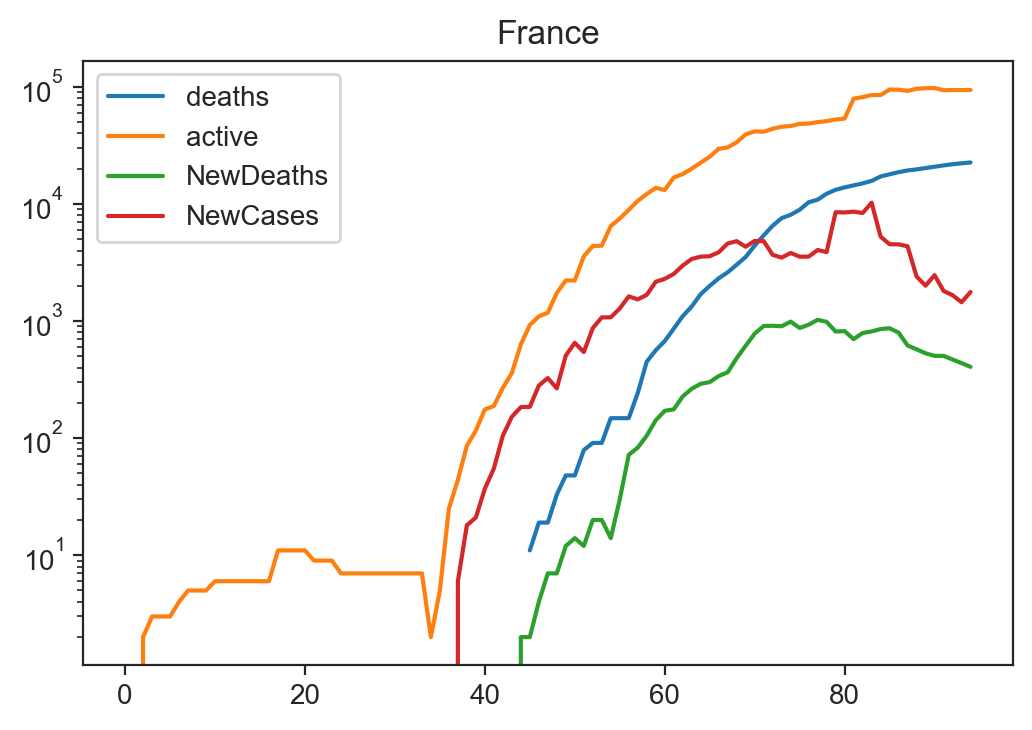

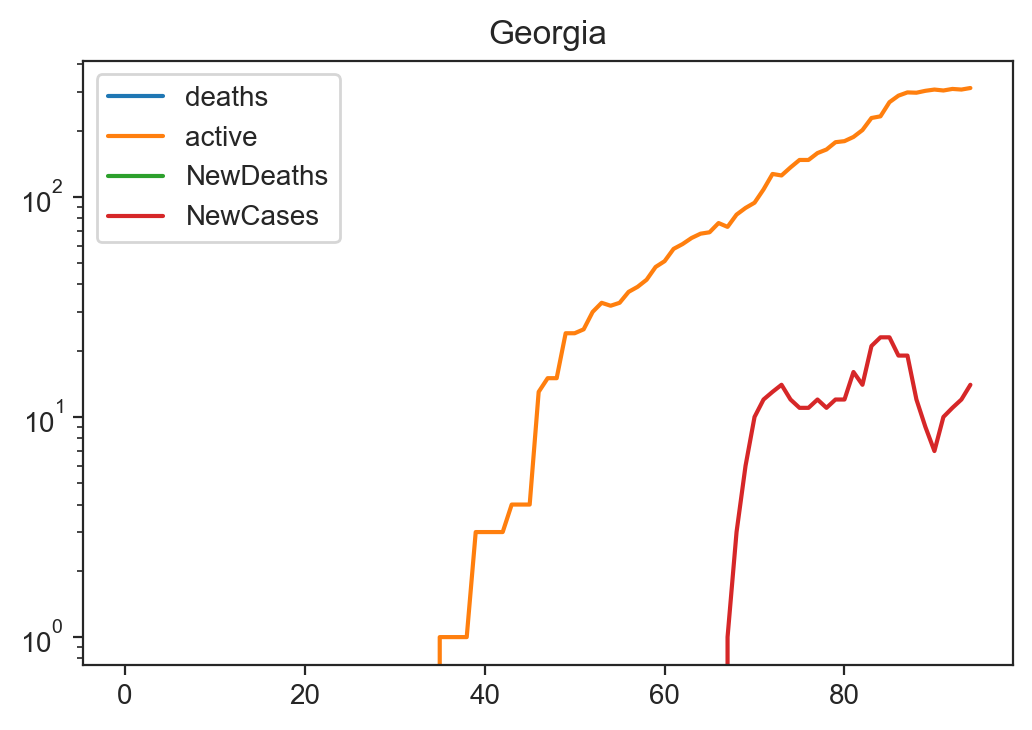

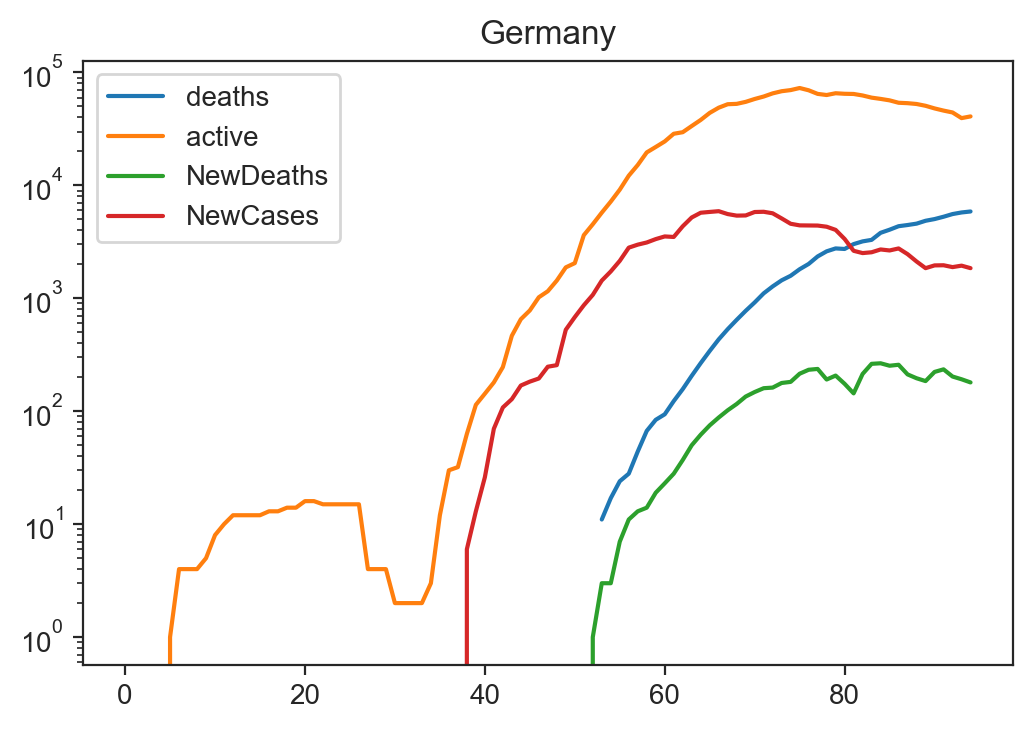

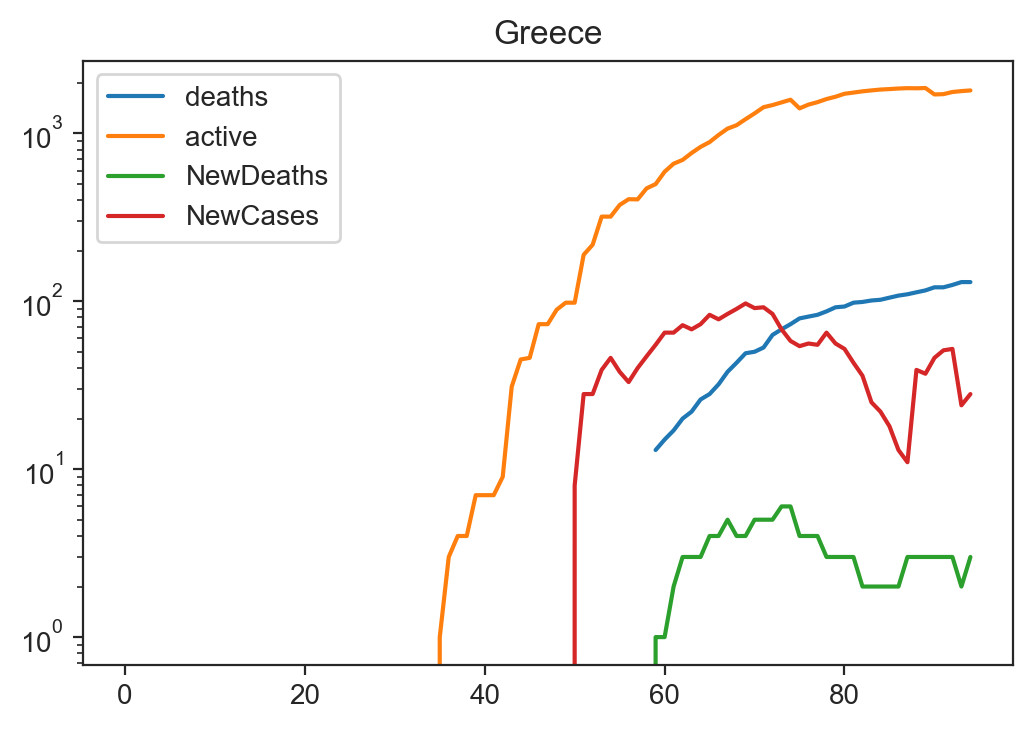

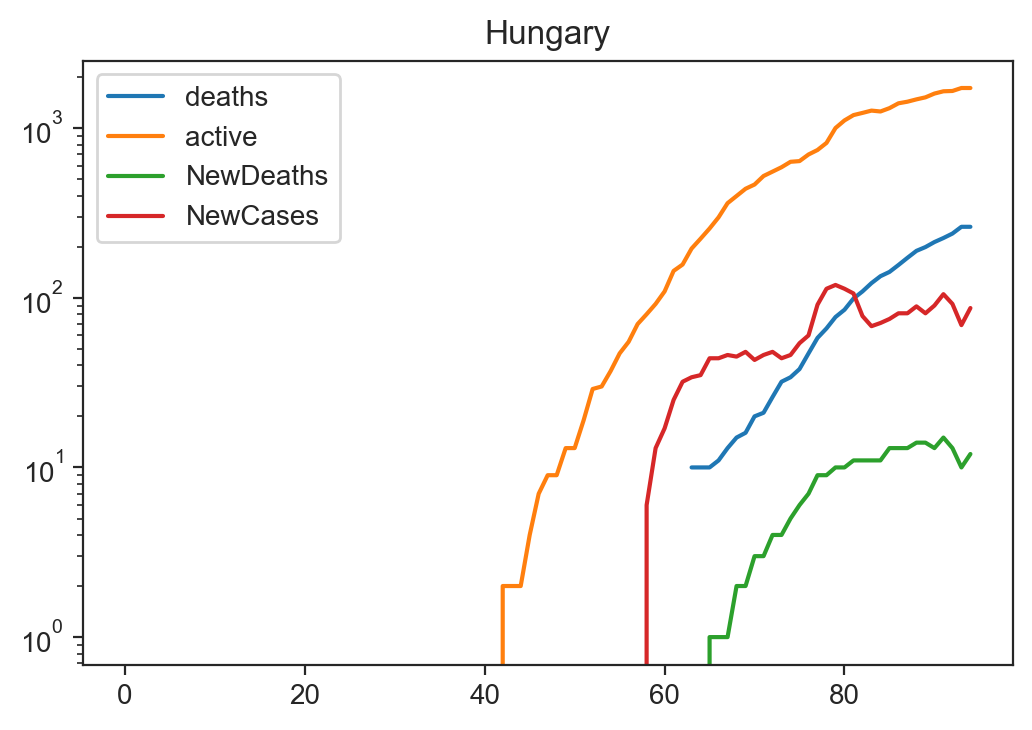

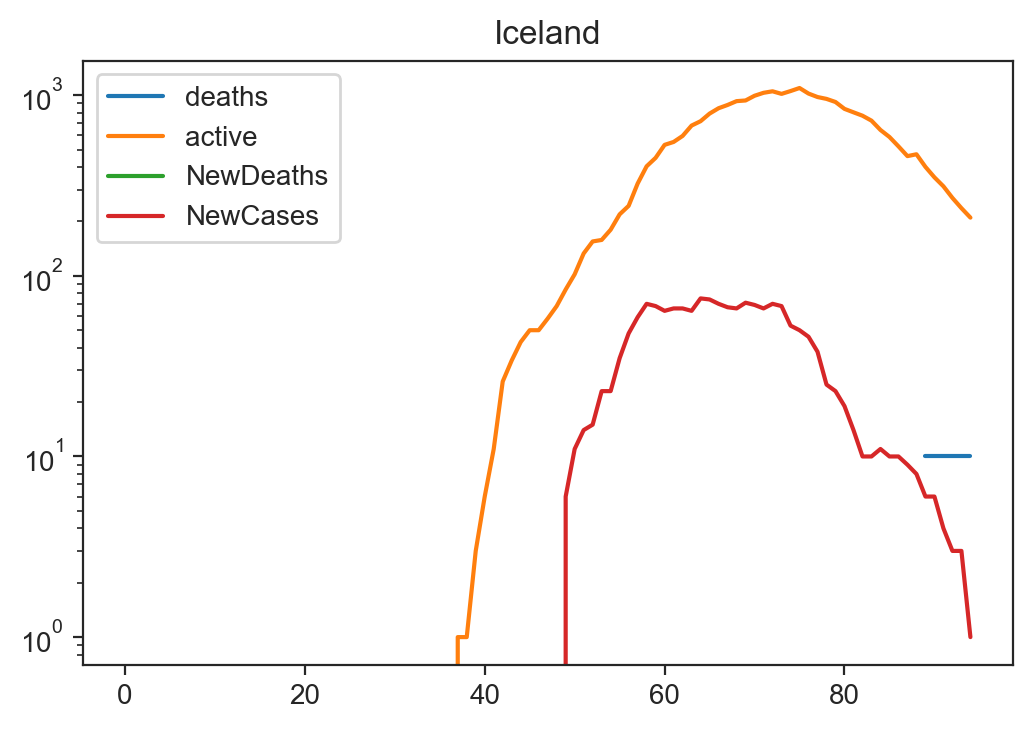

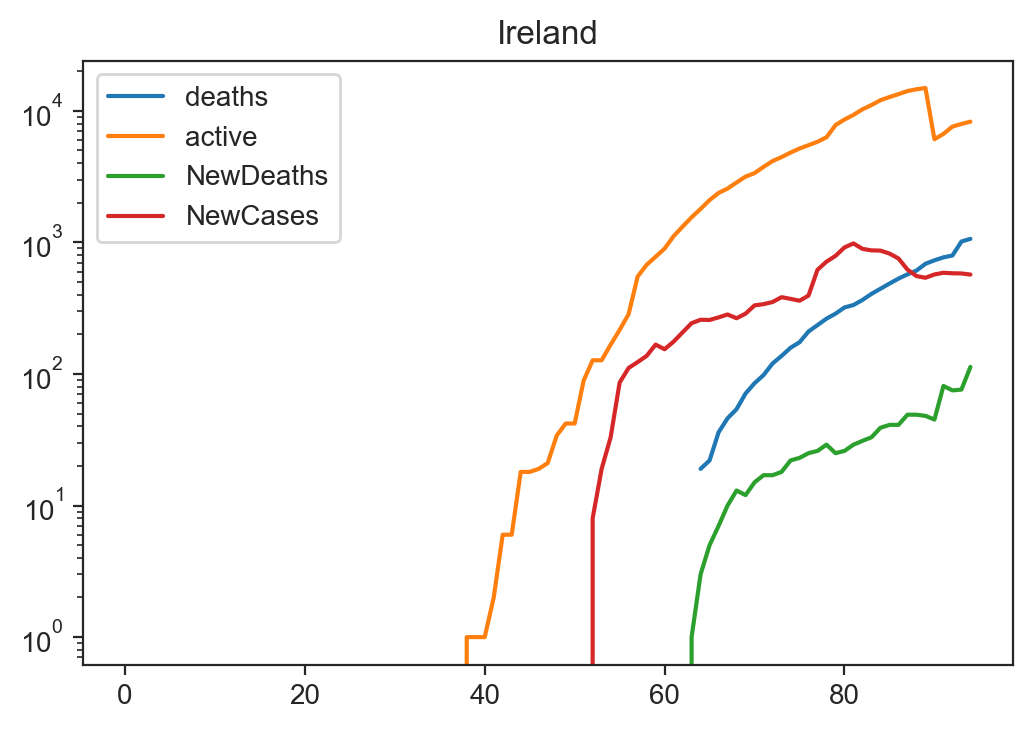

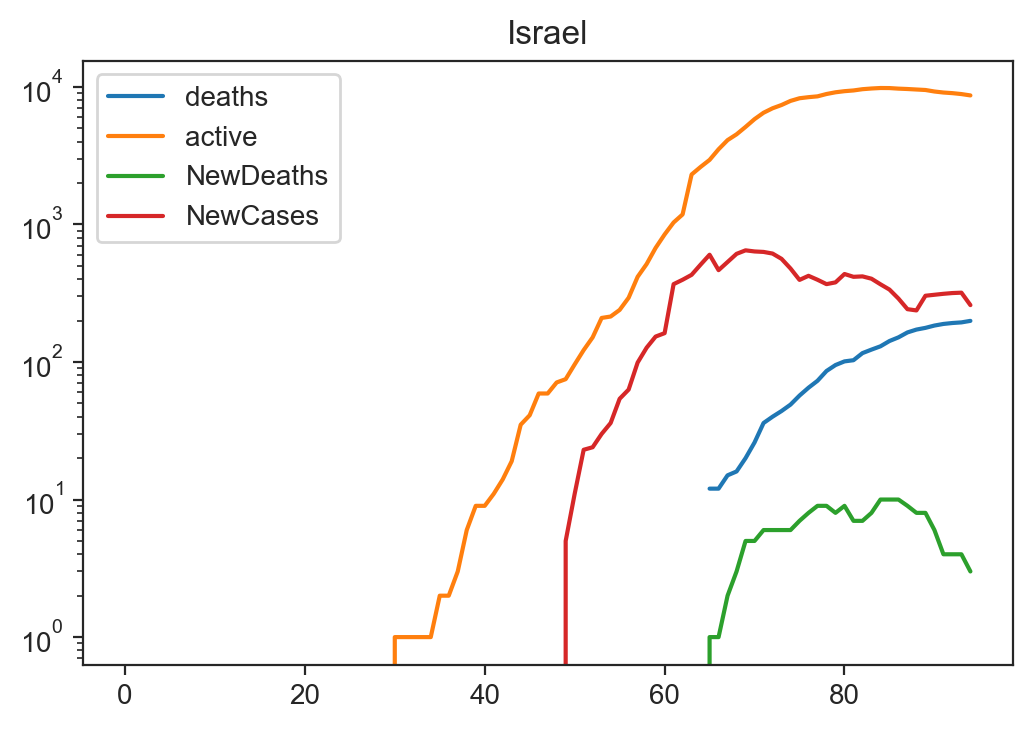

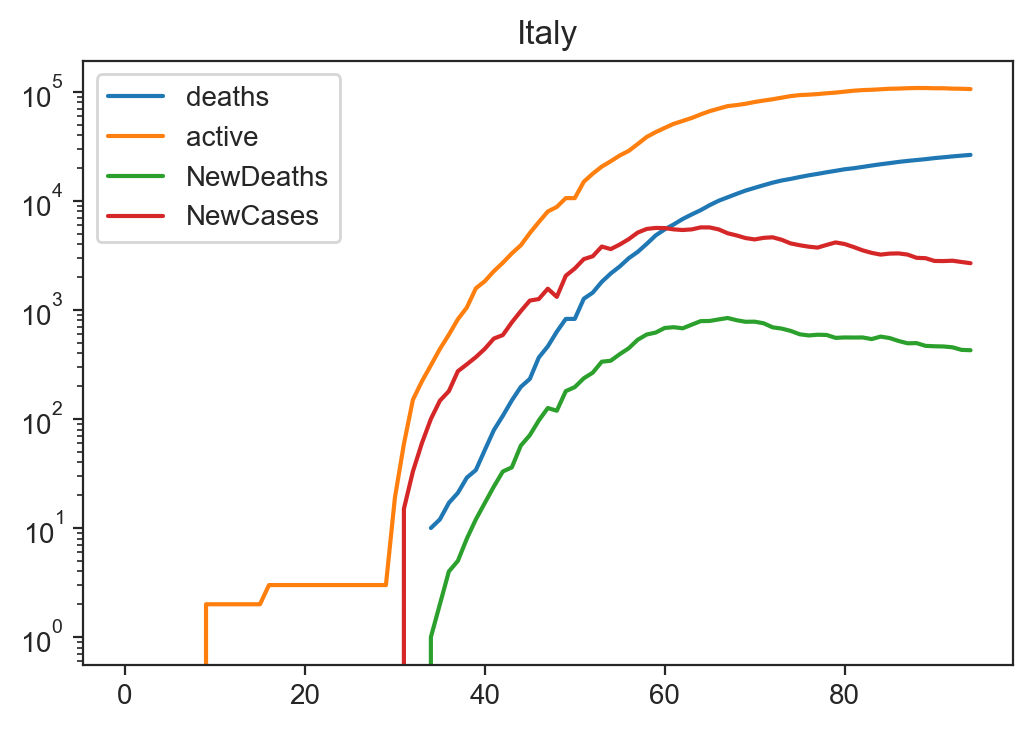

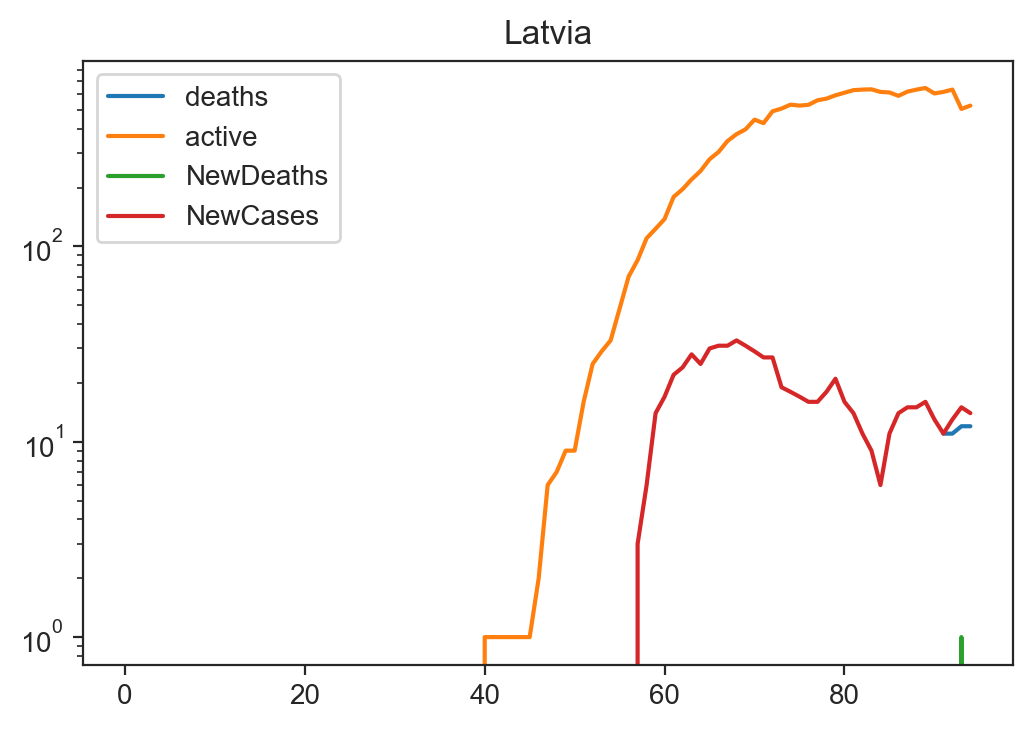

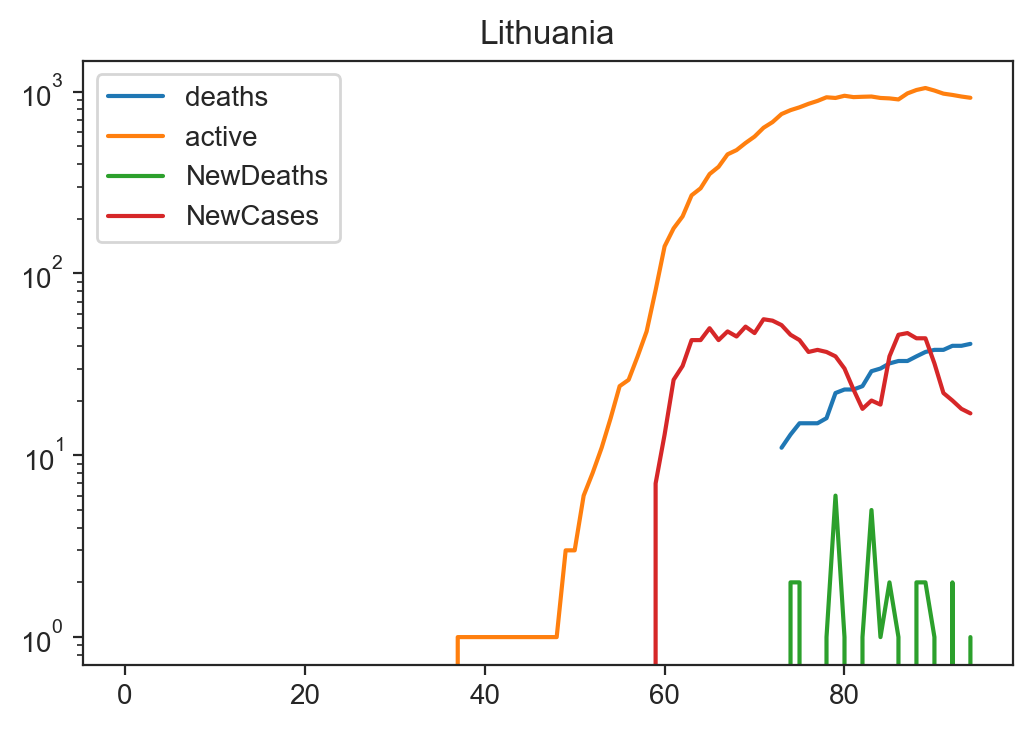

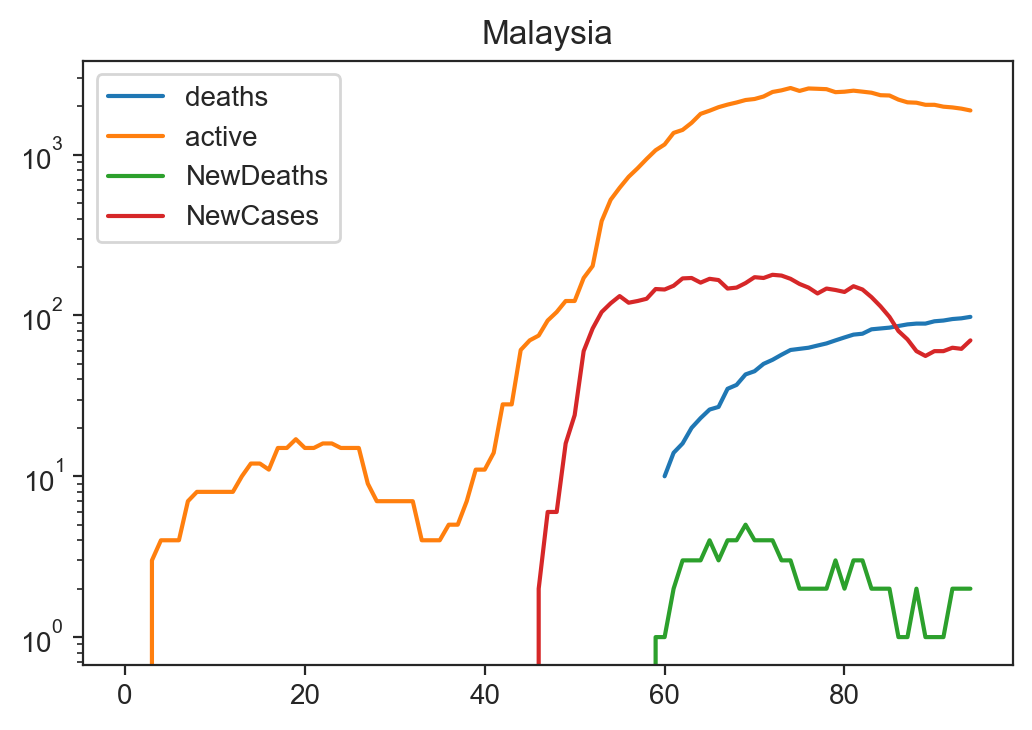

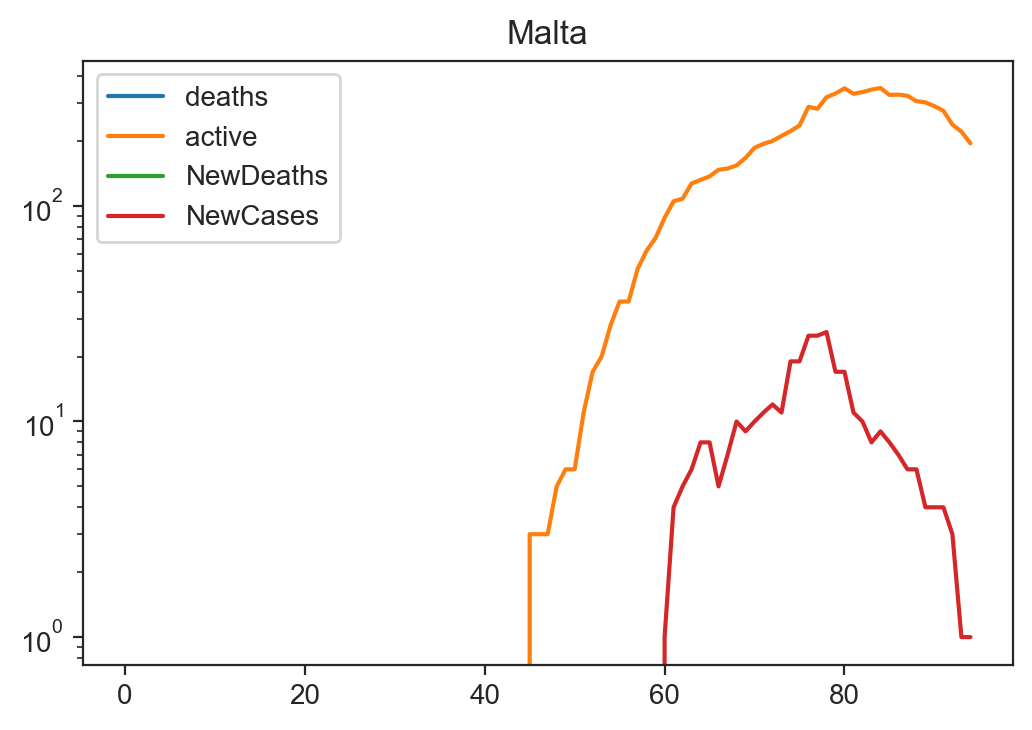

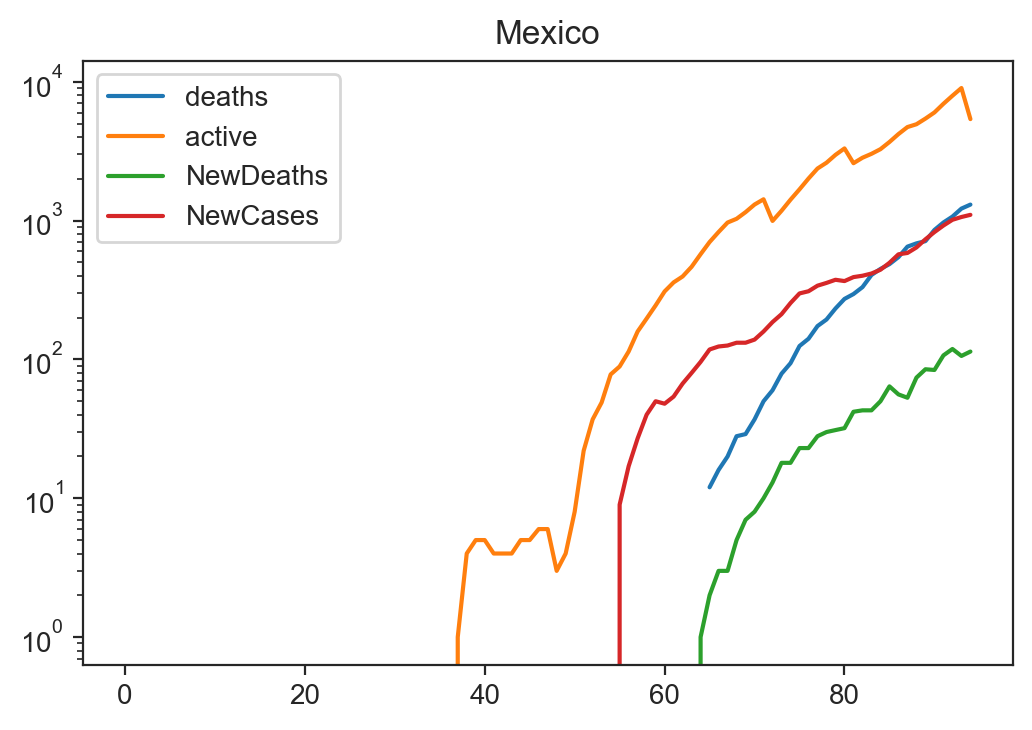

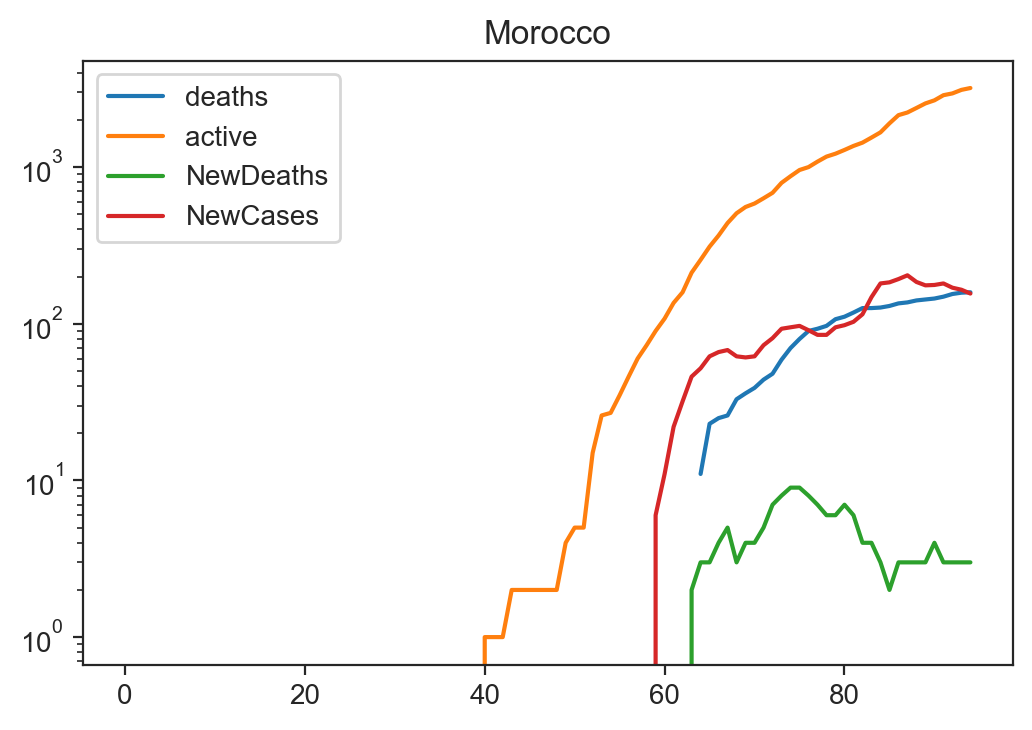

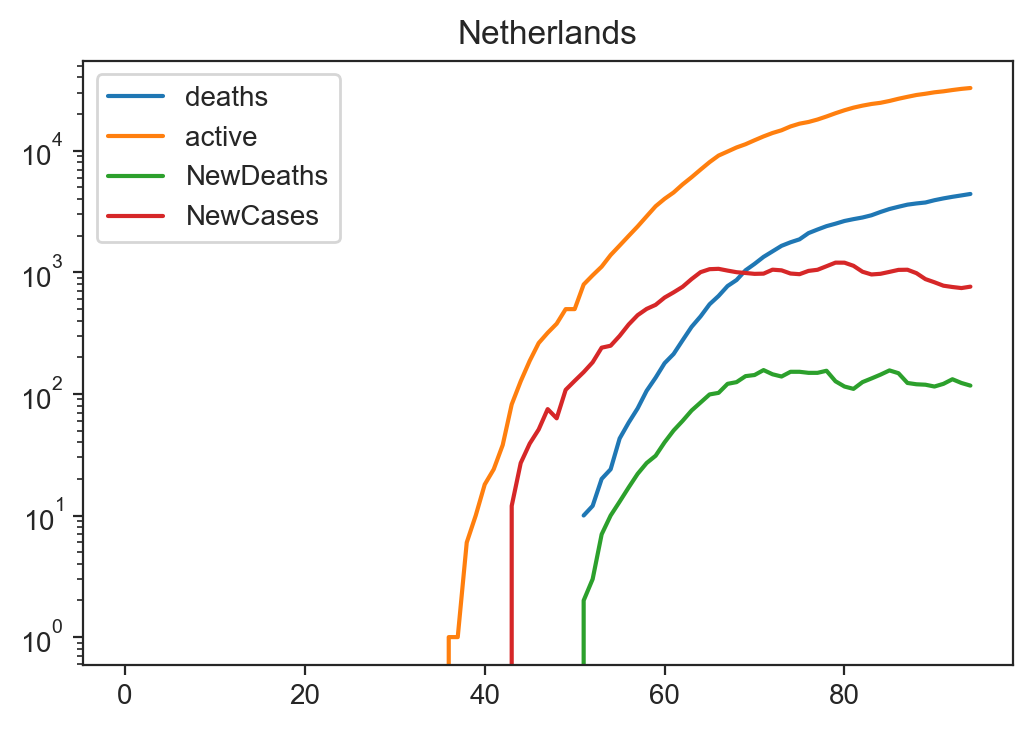

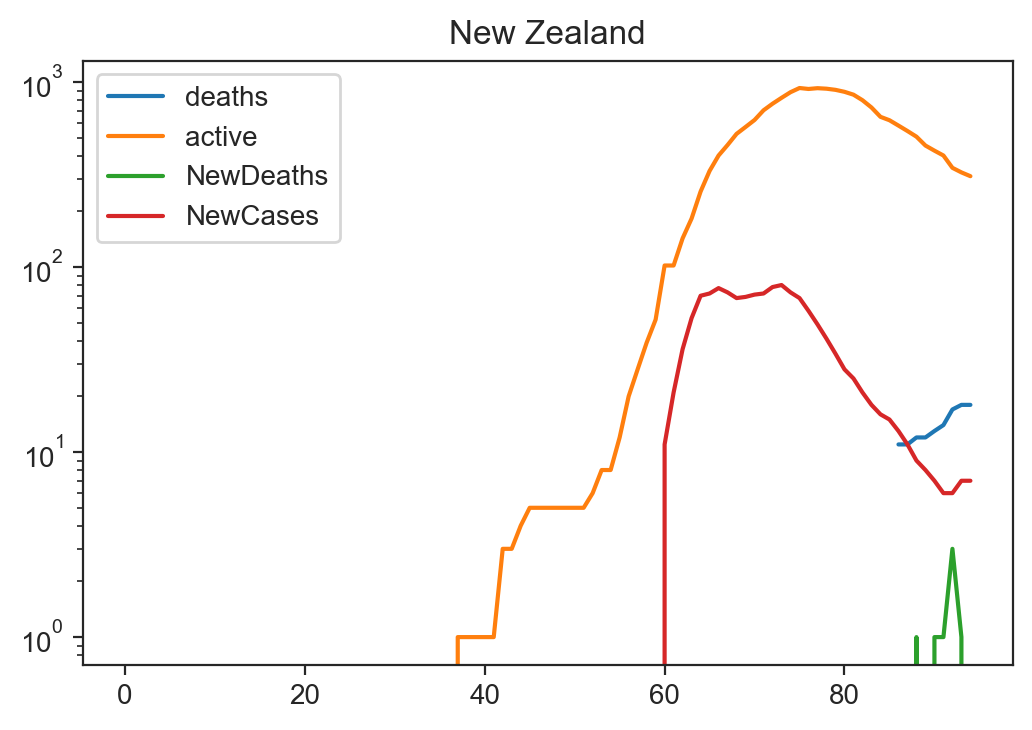

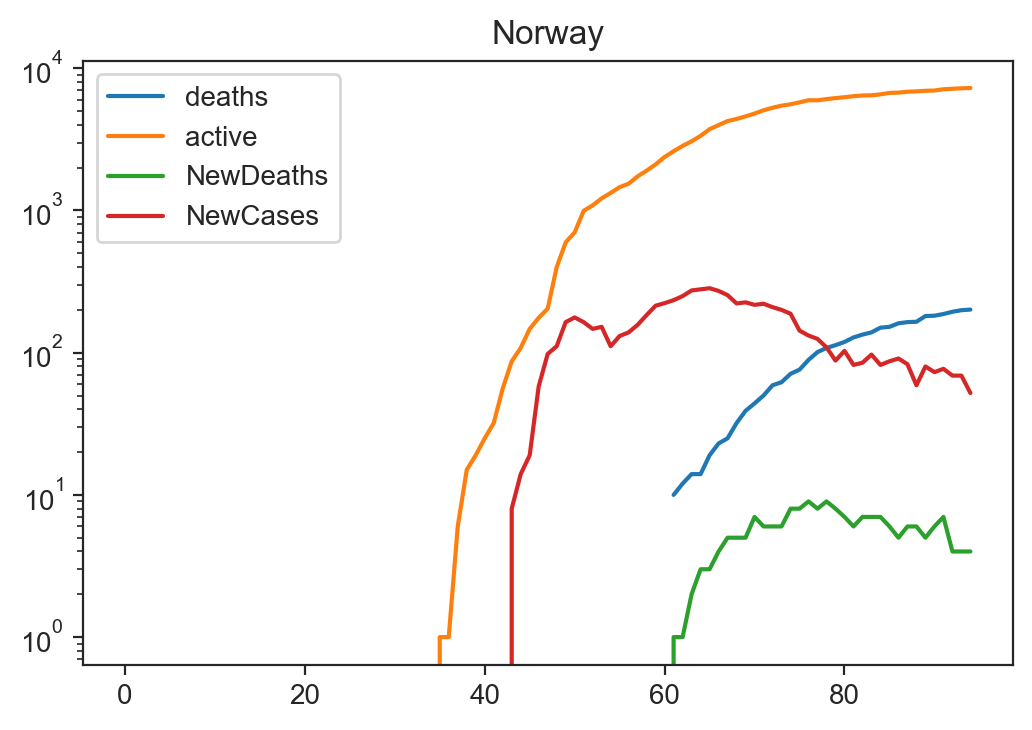

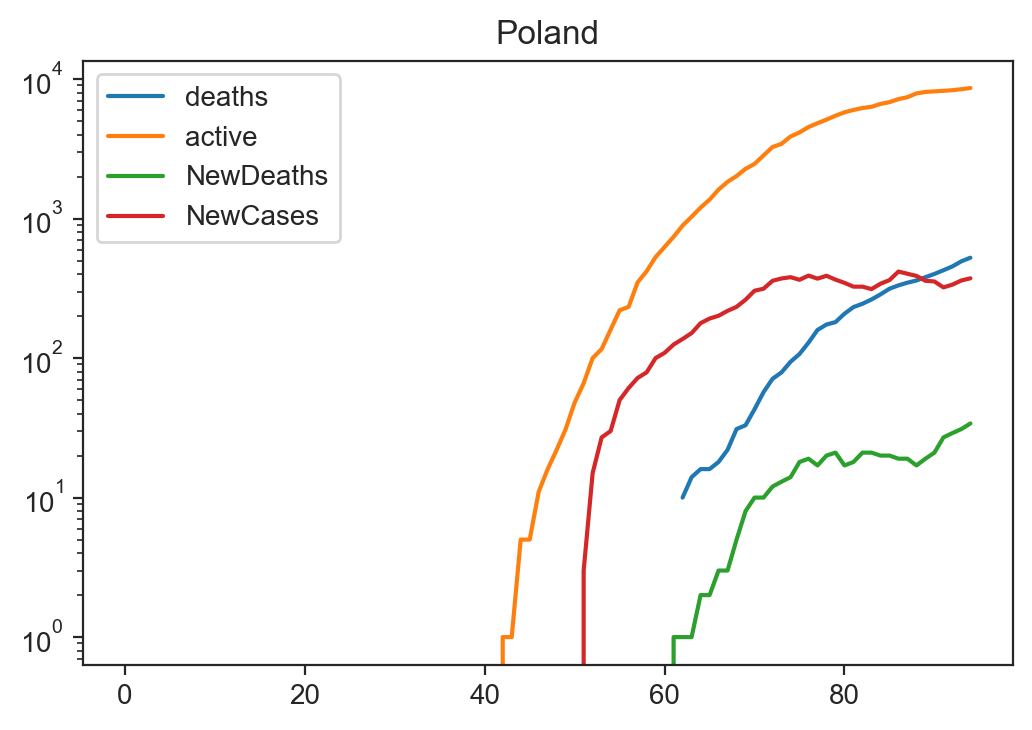

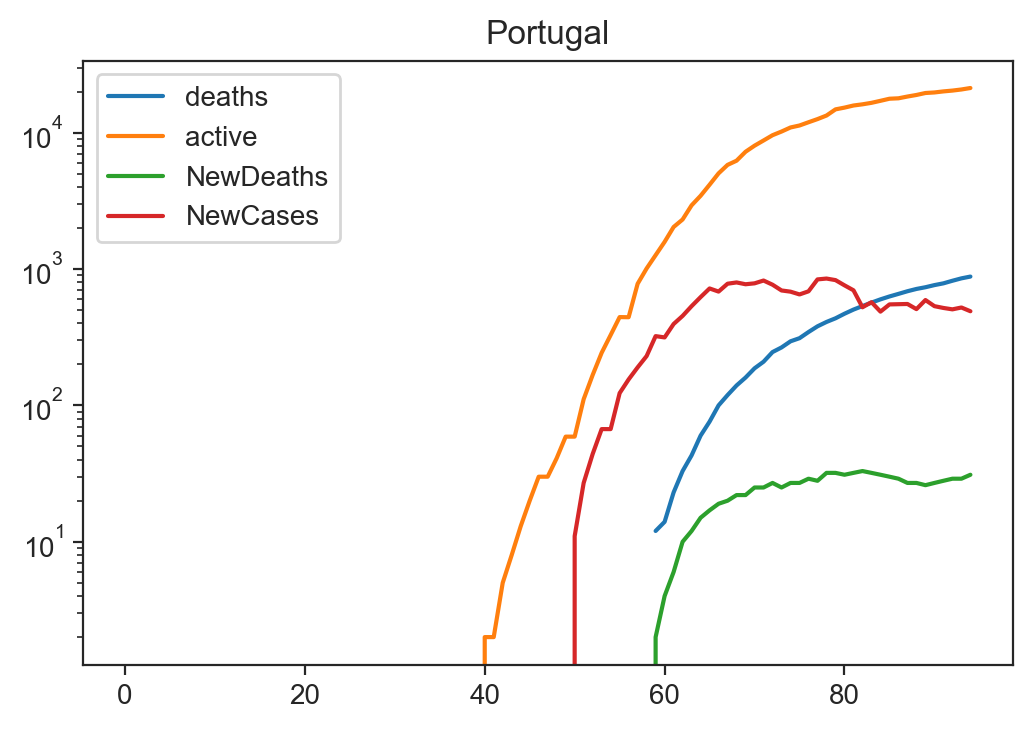

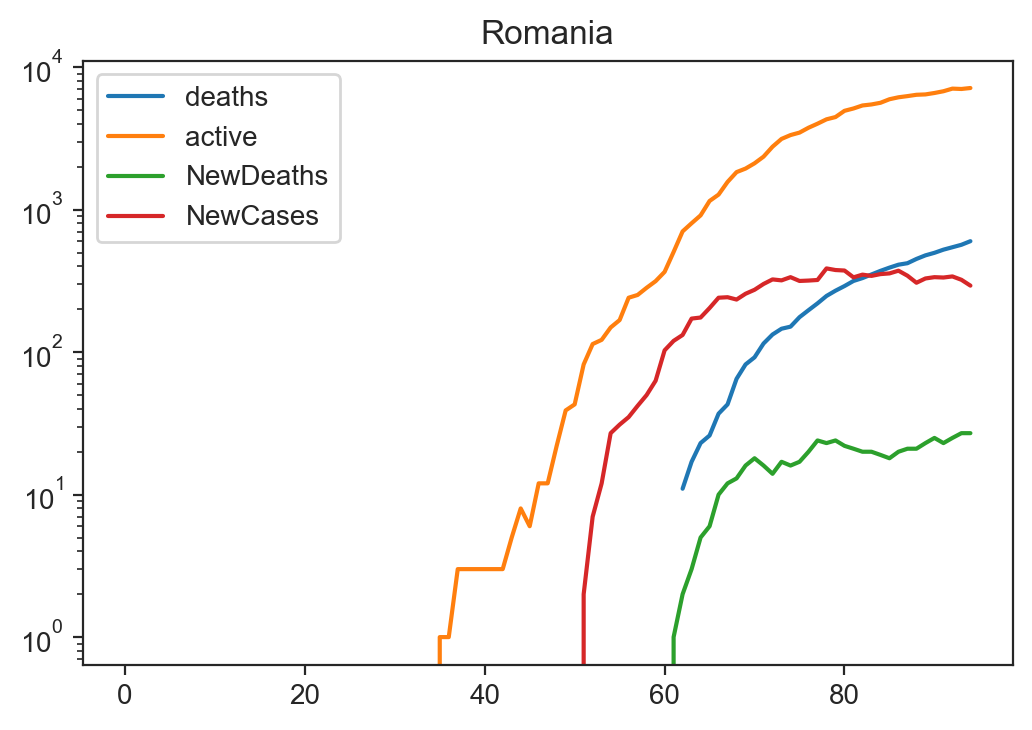

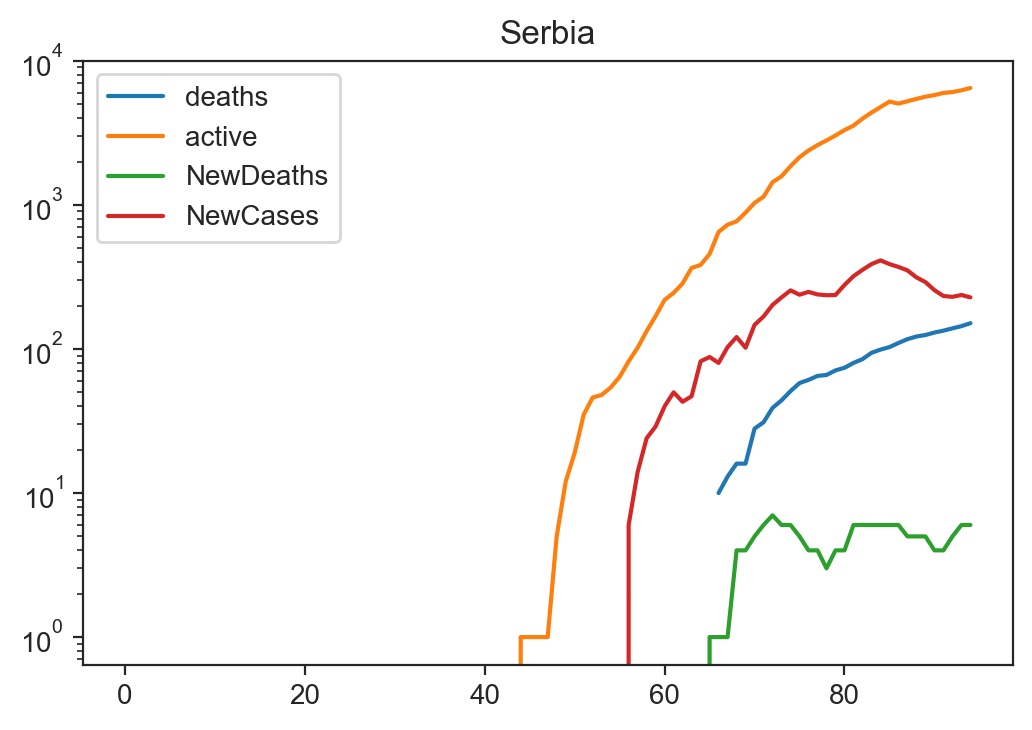

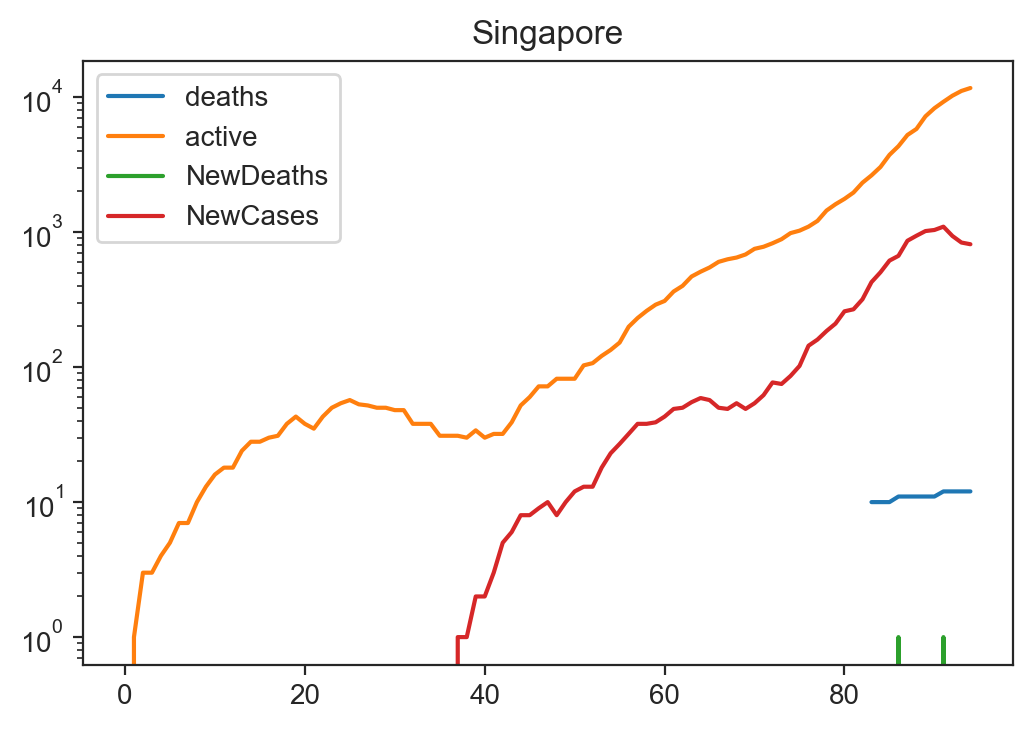

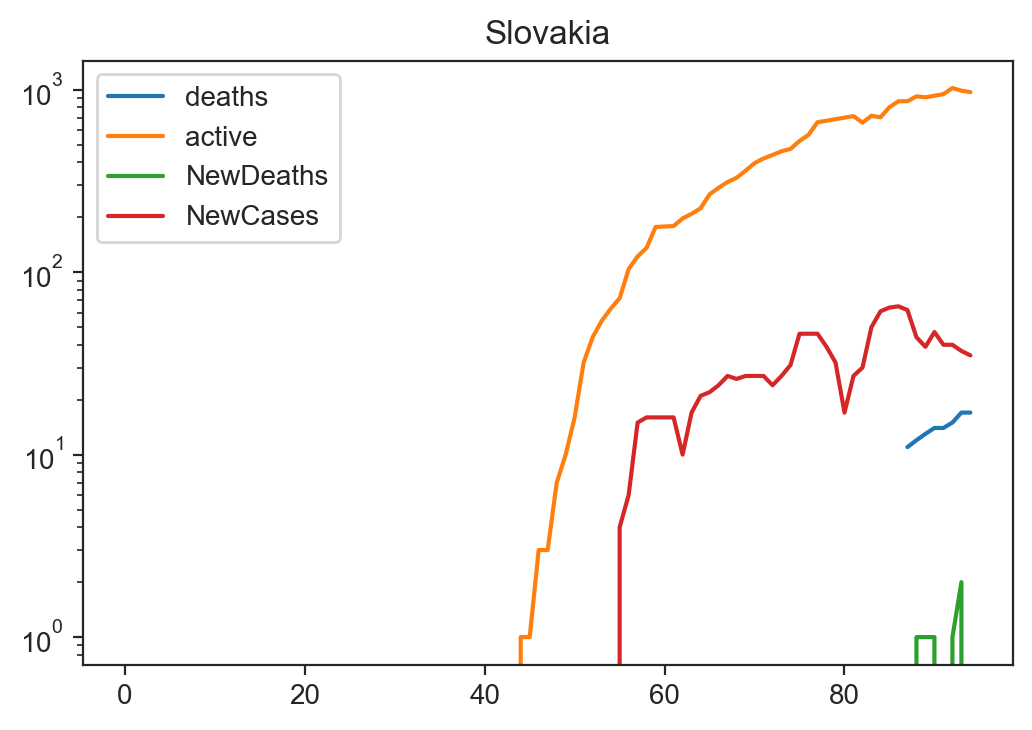

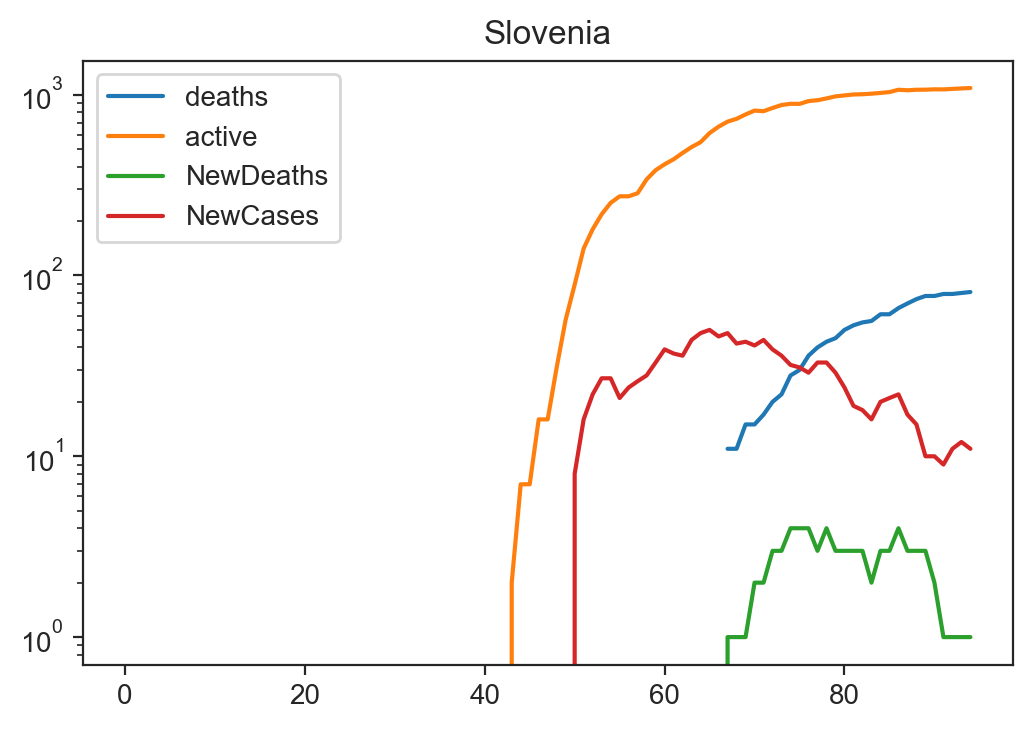

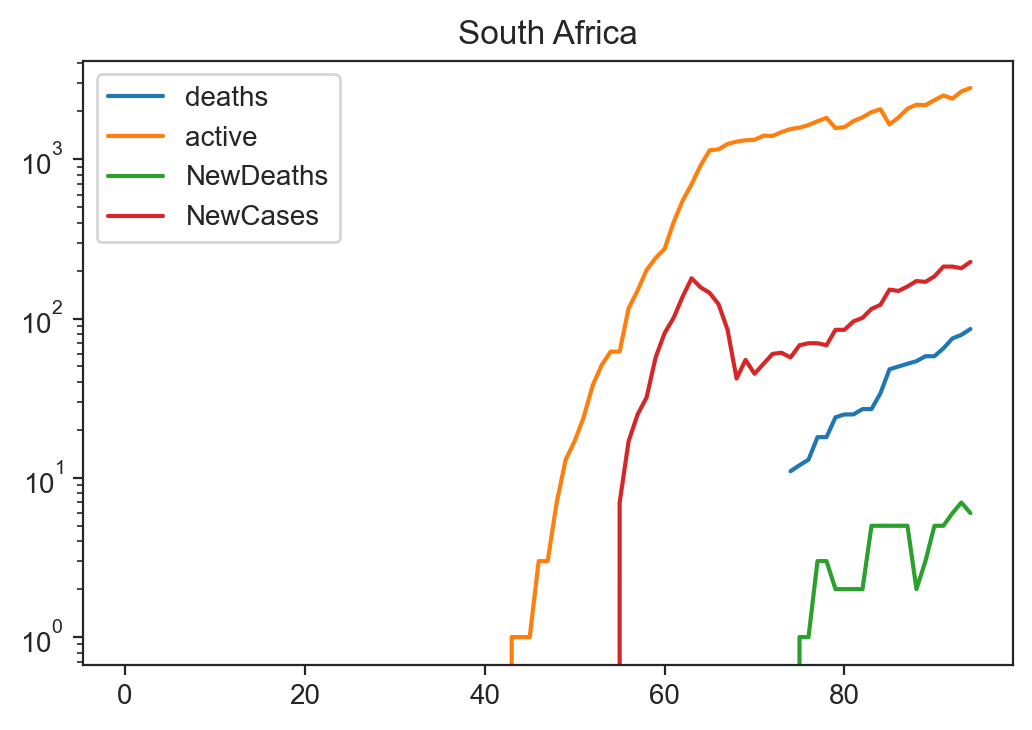

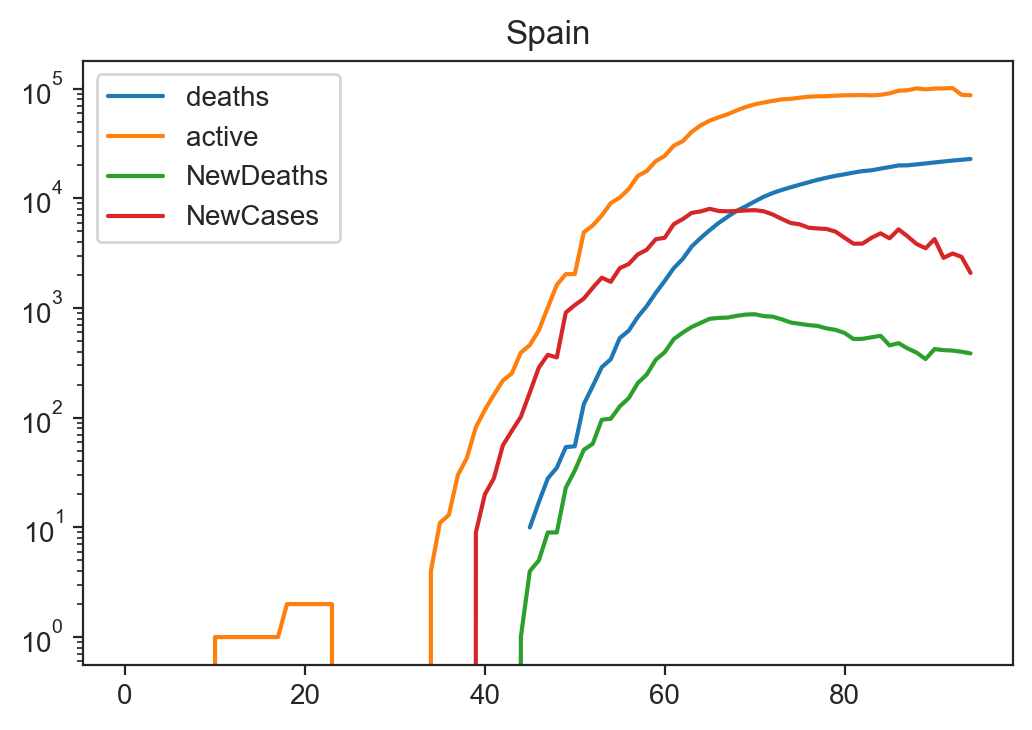

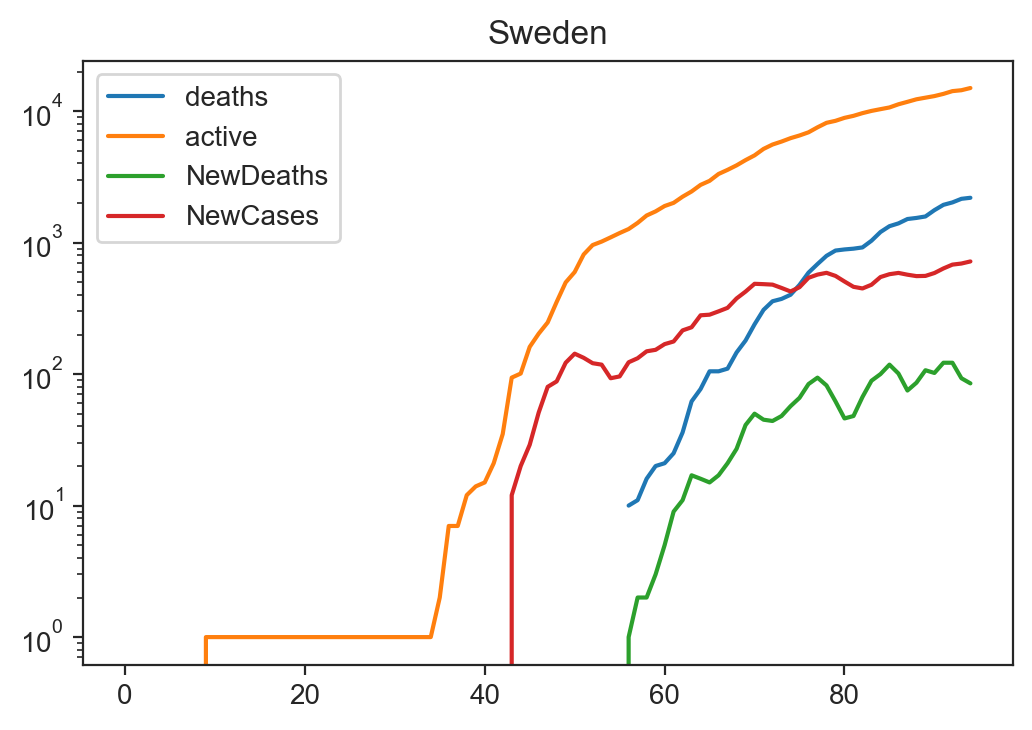

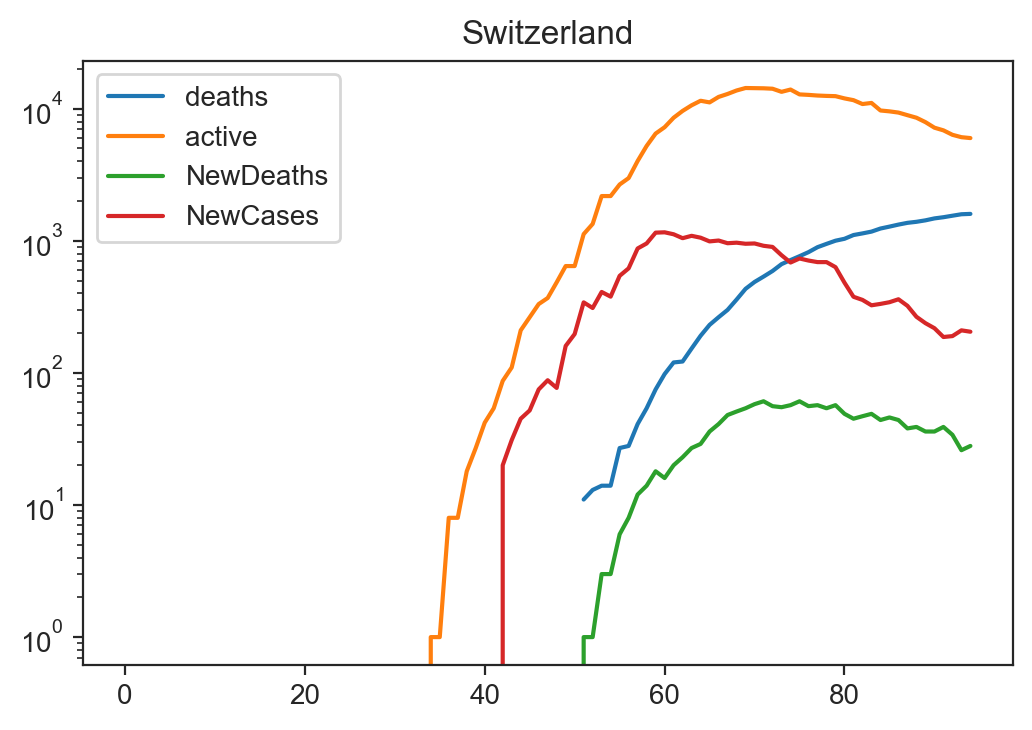

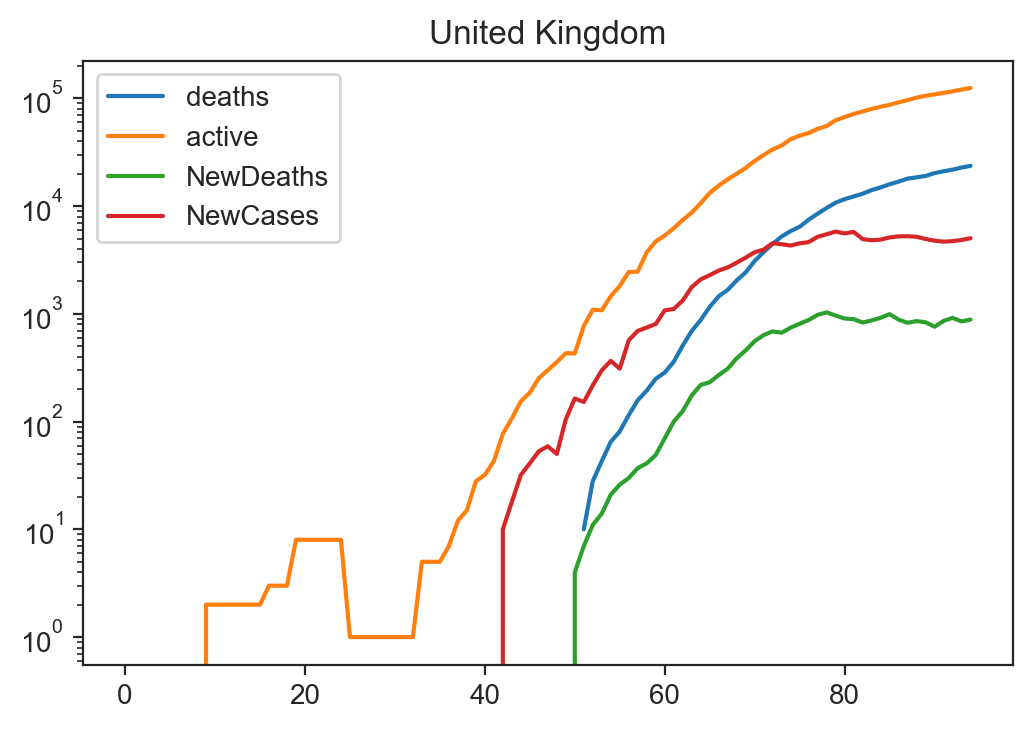

In [33]:
print(data.Ds[-1])
for indx, region in enumerate(region_names):
    if data.Deaths[indx, -1] > 40 and data.Deaths[indx, -1] < 100:
        print(f"{region}, {data.Deaths[indx, -1]}")

for indx, region in enumerate(region_names):
    dts = data.Ds
    locs = np.arange(0, nDs, 7)
    xlabels = [f"{dts[ts].day}-{dts[ts].month}" for ts in locs]
    plt.figure(dpi=200)
    plt.plot(np.arange(len(dts)), data.Deaths[indx, :], label="deaths")
    plt.plot(np.arange(len(dts)), data.Active[indx, :], label="active")
    plt.plot(np.arange(len(dts)), data.NewDeaths[indx, :], label="NewDeaths")
    plt.plot(np.arange(len(dts)), data.NewCases[indx, :], label="NewCases")
    plt.legend()
    plt.yscale("log")
    plt.title(region)

In [34]:
ActiveCMs = data.ActiveCMs
_, nCMs, _ = ActiveCMs.shape

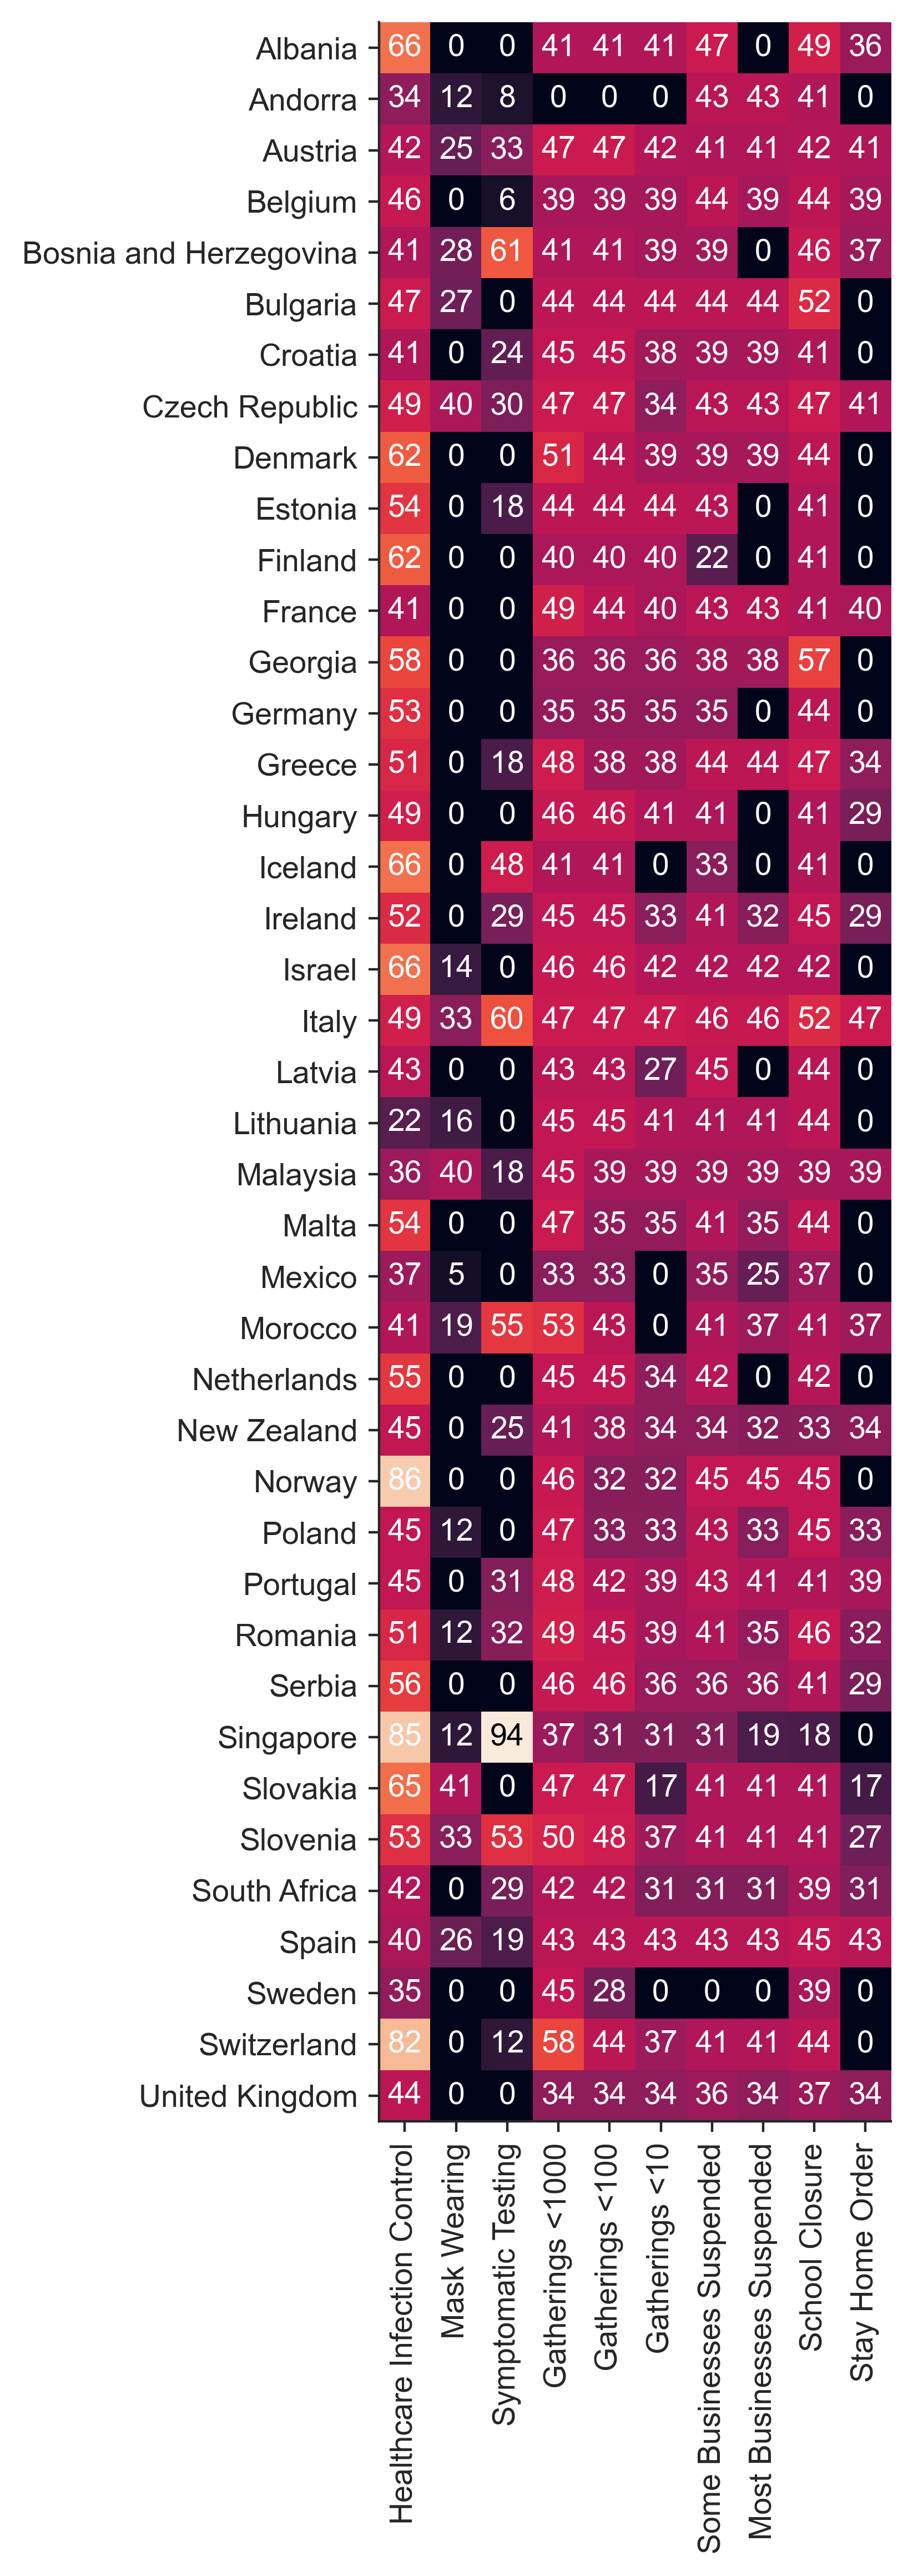

In [35]:
days_active_table = np.zeros(shape=(len(region_info), nCMs))
for d_indx, region in enumerate(region_info):
    for indx, f in enumerate(data.CMs):
        days_active_table[d_indx, indx] = np.sum(ActiveCMs[d_indx, indx, :])

fig = plt.figure(figsize=(8.3, 11.7), dpi=400)
plt.imshow(days_active_table)

for r in range(len(region_info)):
    for cm in range(len(data.CMs)):
        num = days_active_table[r, cm]
        if num < 90:
            plt.text(cm, r, f"{num:.0f}", color="white", horizontalalignment="center", verticalalignment="center")
        else:
            plt.text(cm, r, f"{num:.0f}", color="black", horizontalalignment="center", verticalalignment="center")

plt.yticks(np.arange(len(region_names)), region_names)
plt.xticks(
    np.arange(len(data.CMs)),
    [f for f in data.CMs],
    rotation=90
)
sns.despine()
plt.ylim([len(region_info)-0.5, -0.5])
plt.tight_layout()
plt.savefig("table.pdf")

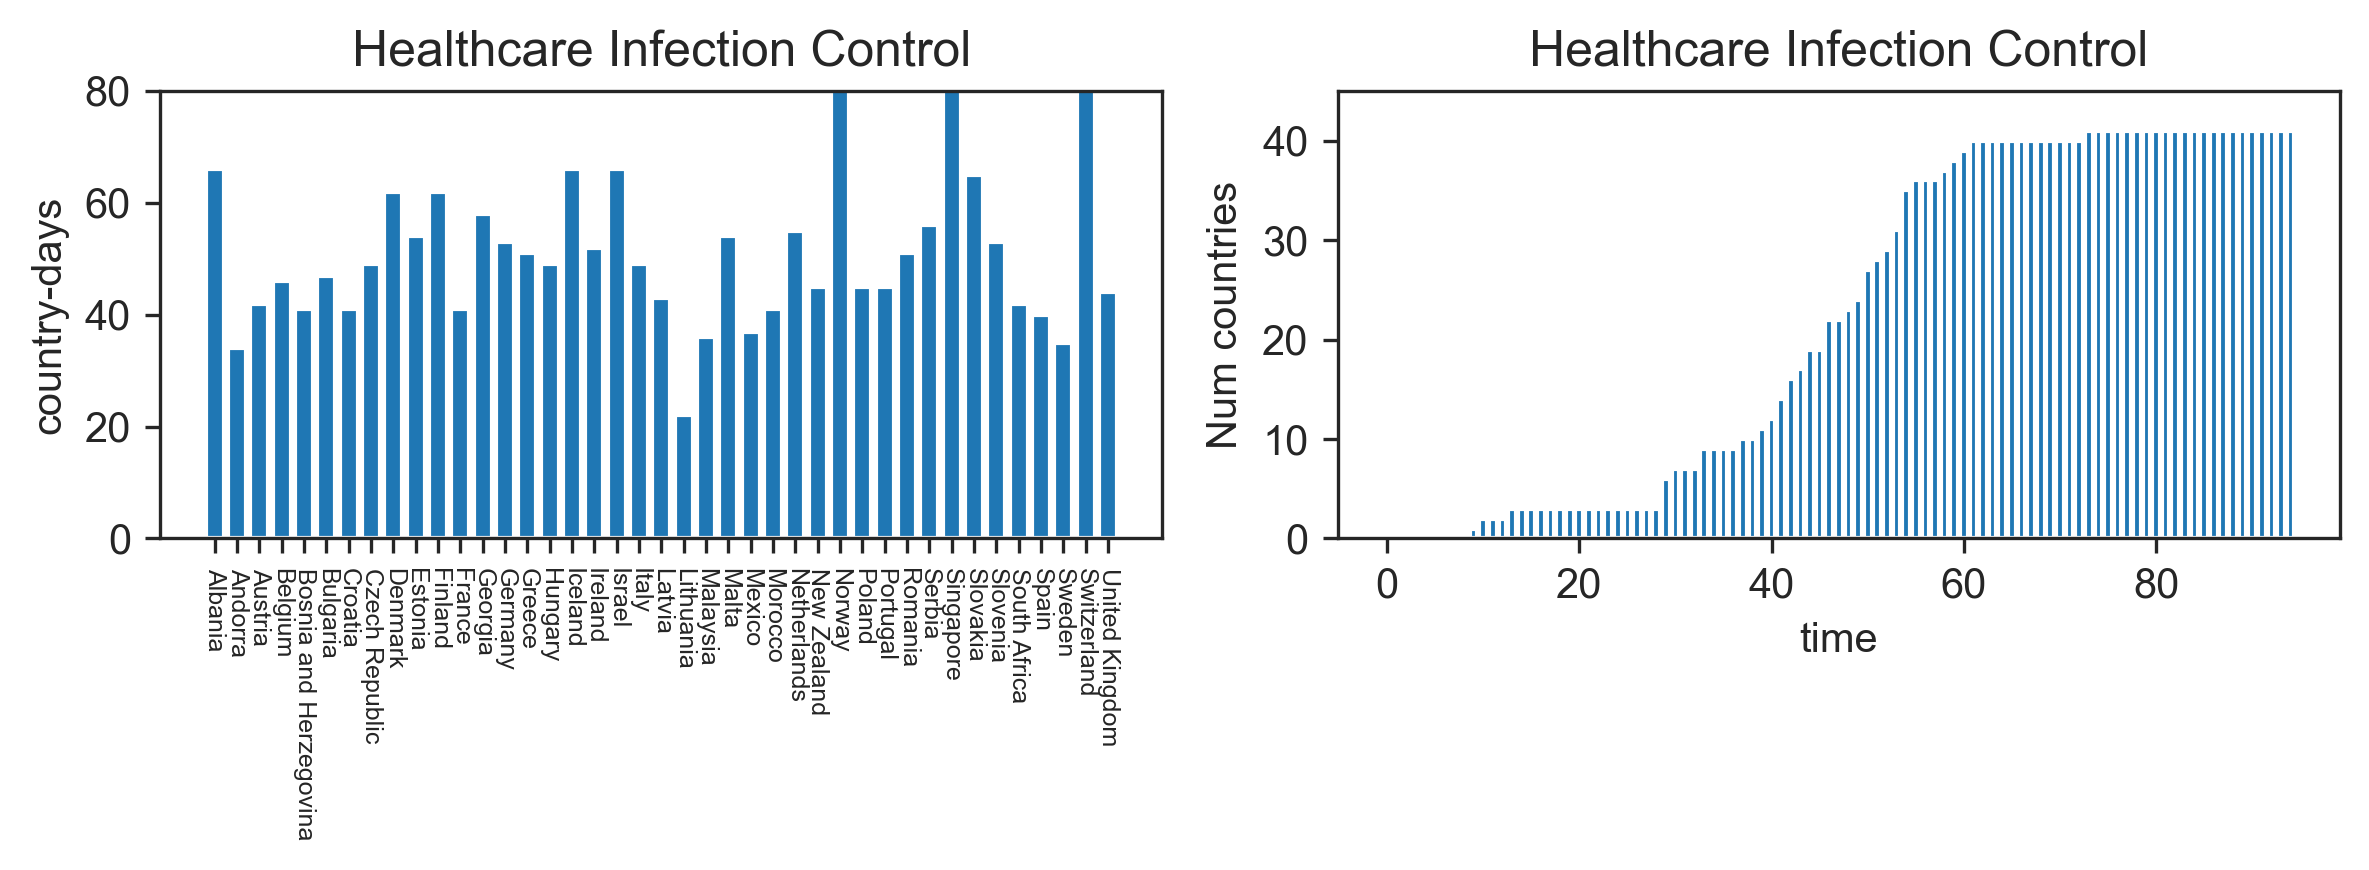

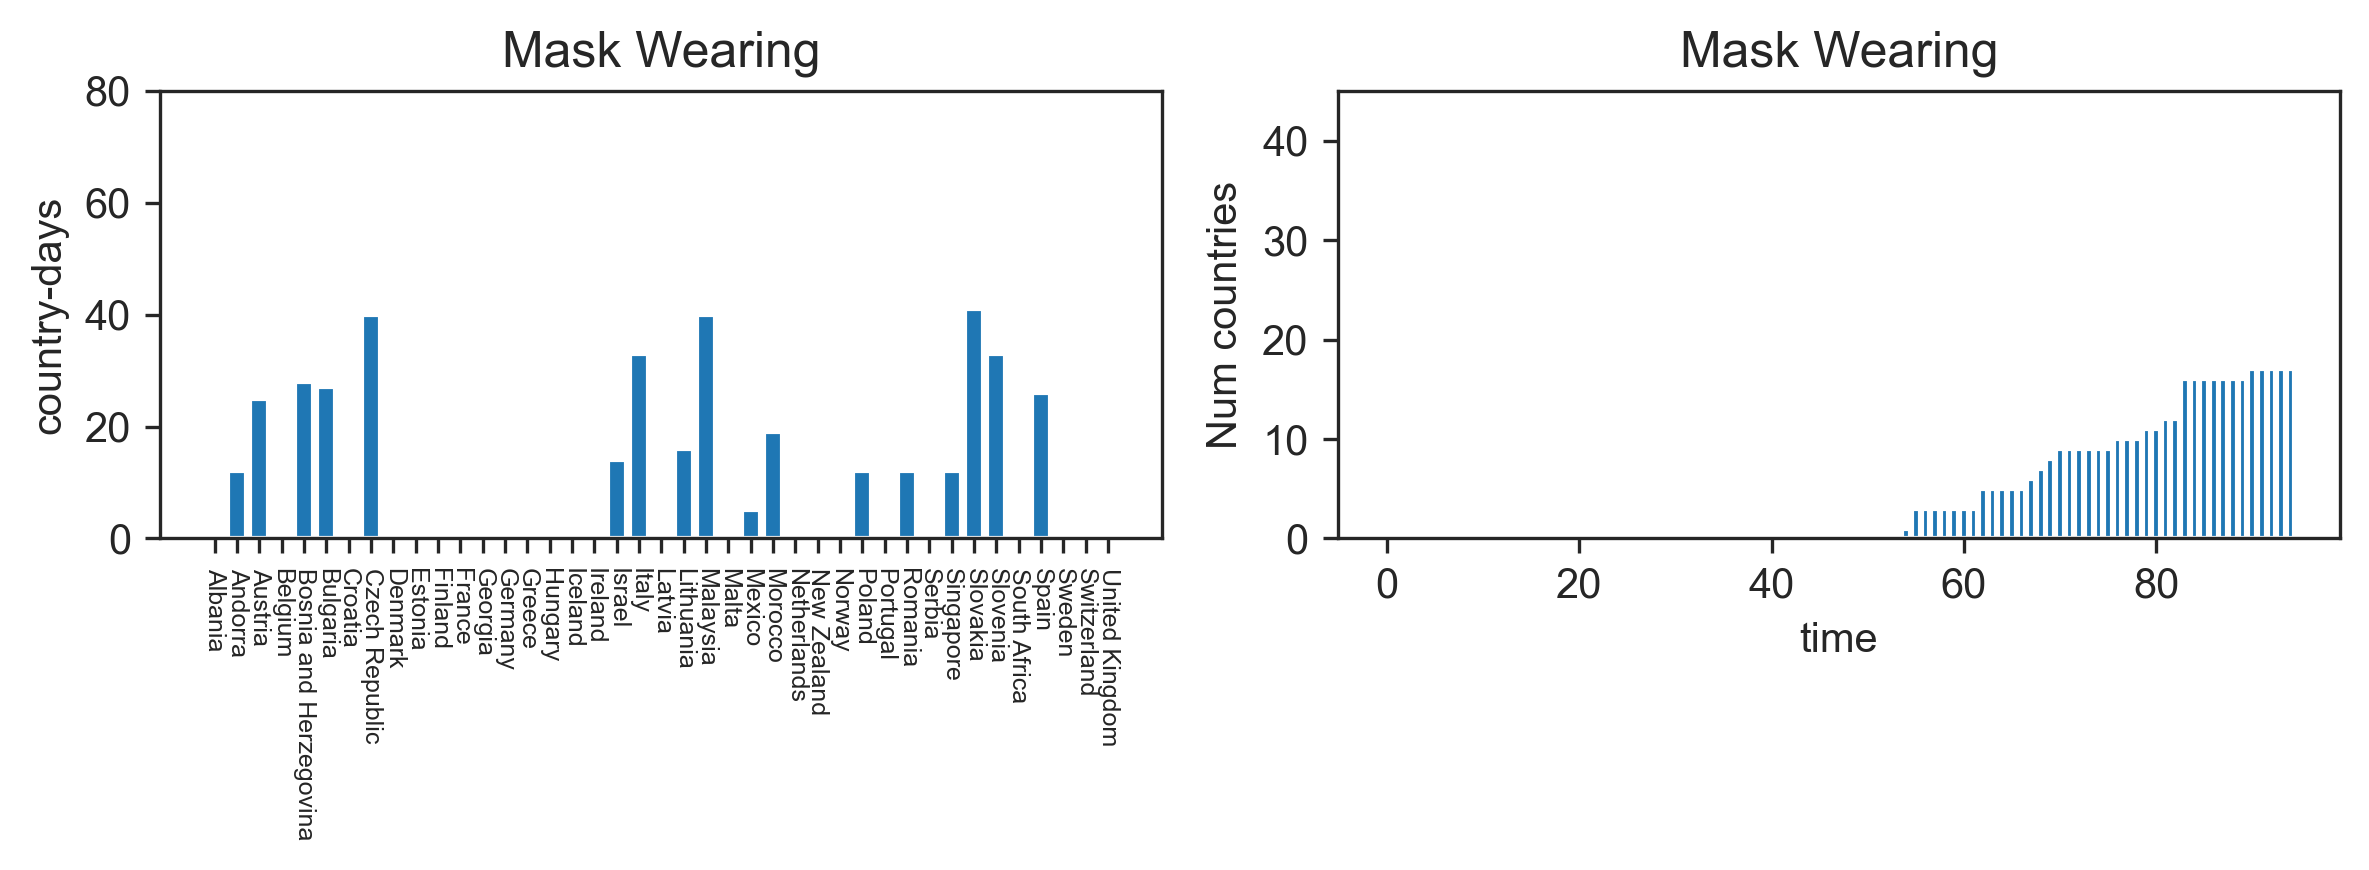

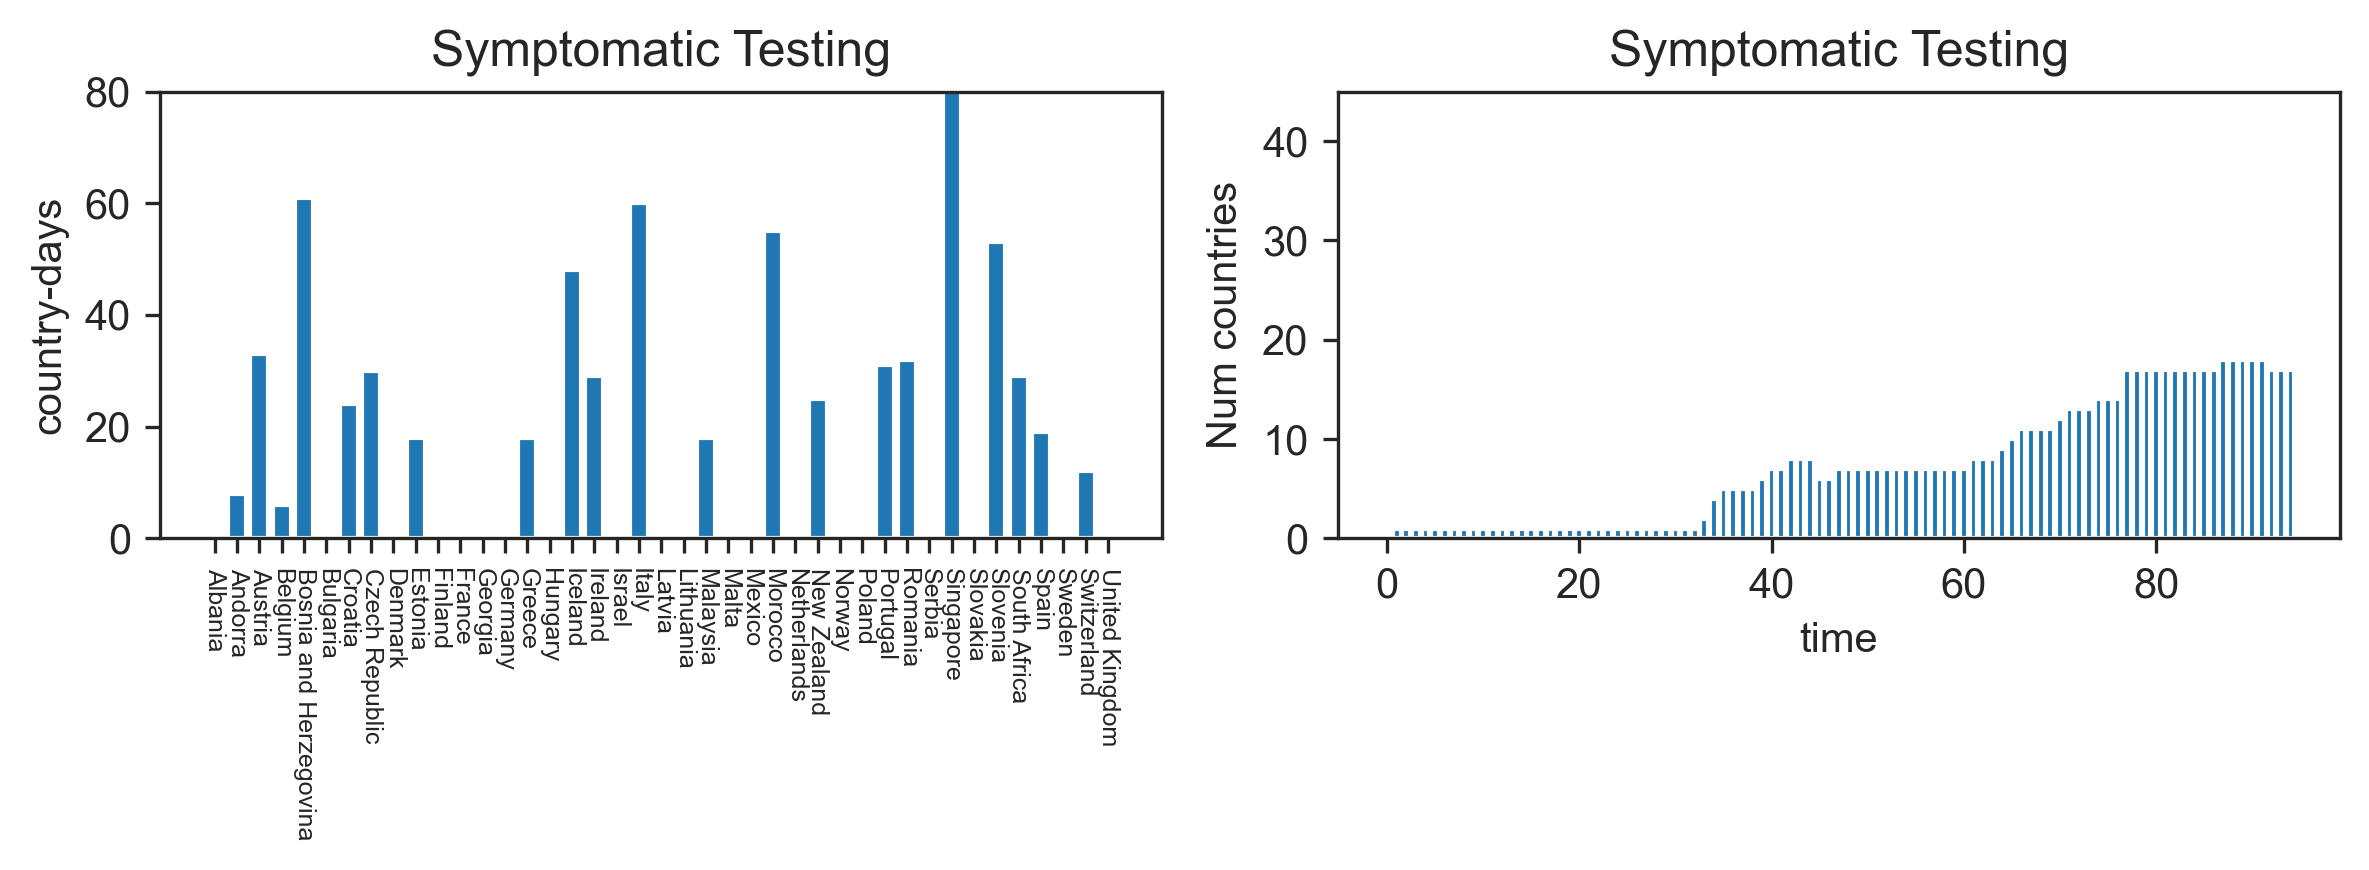

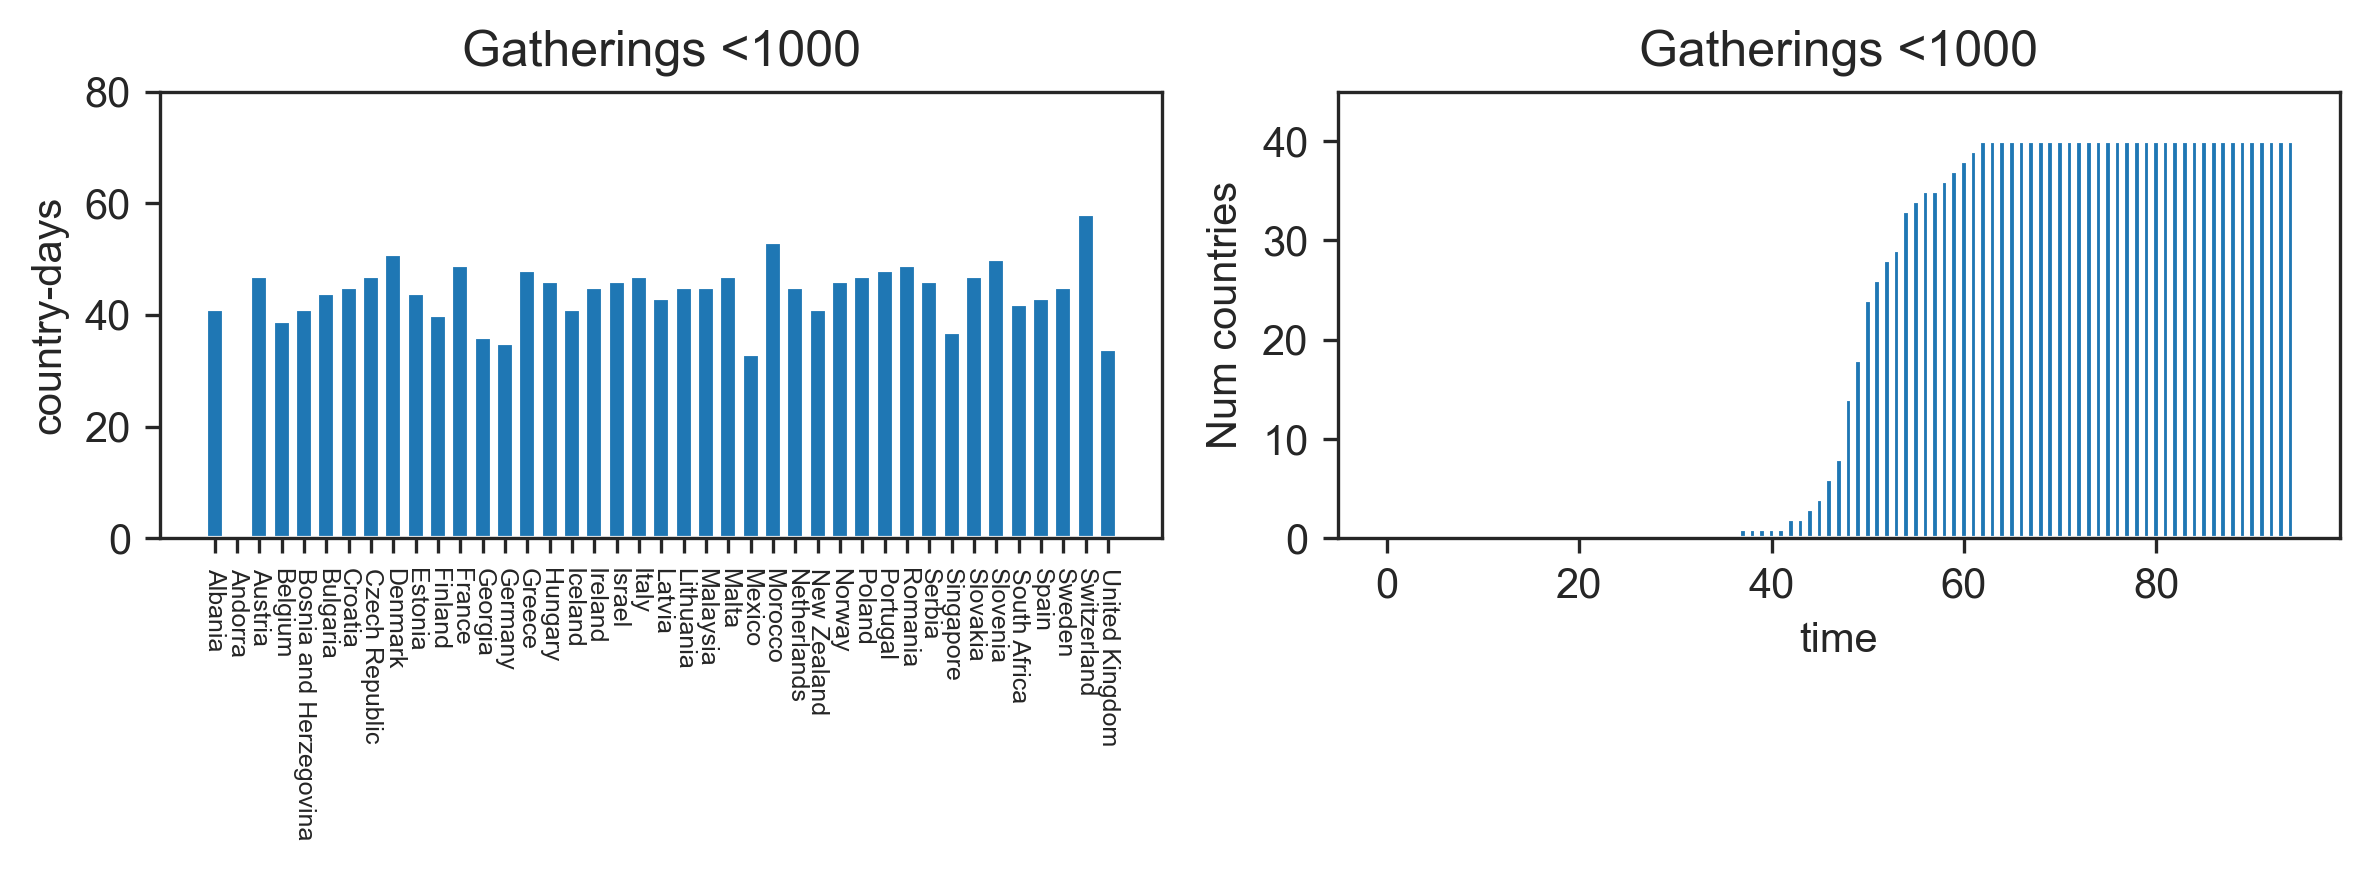

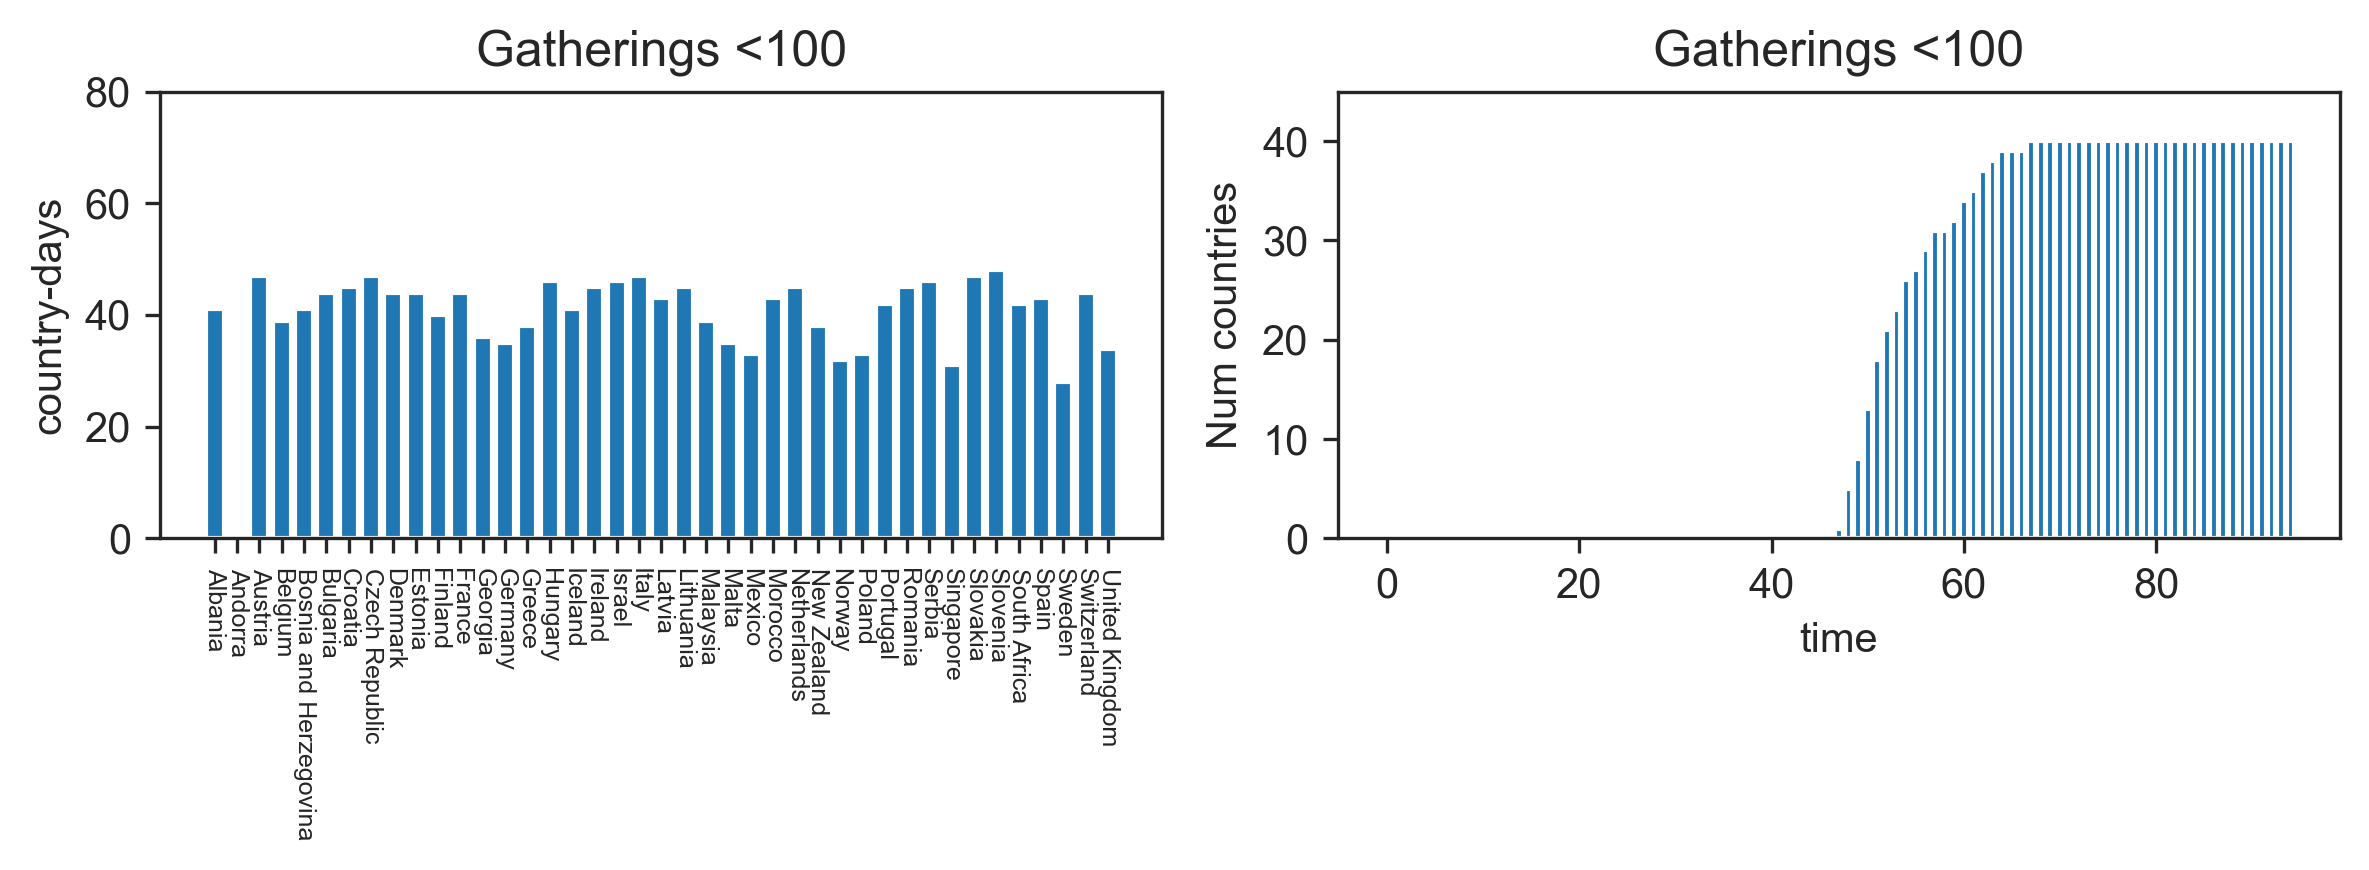

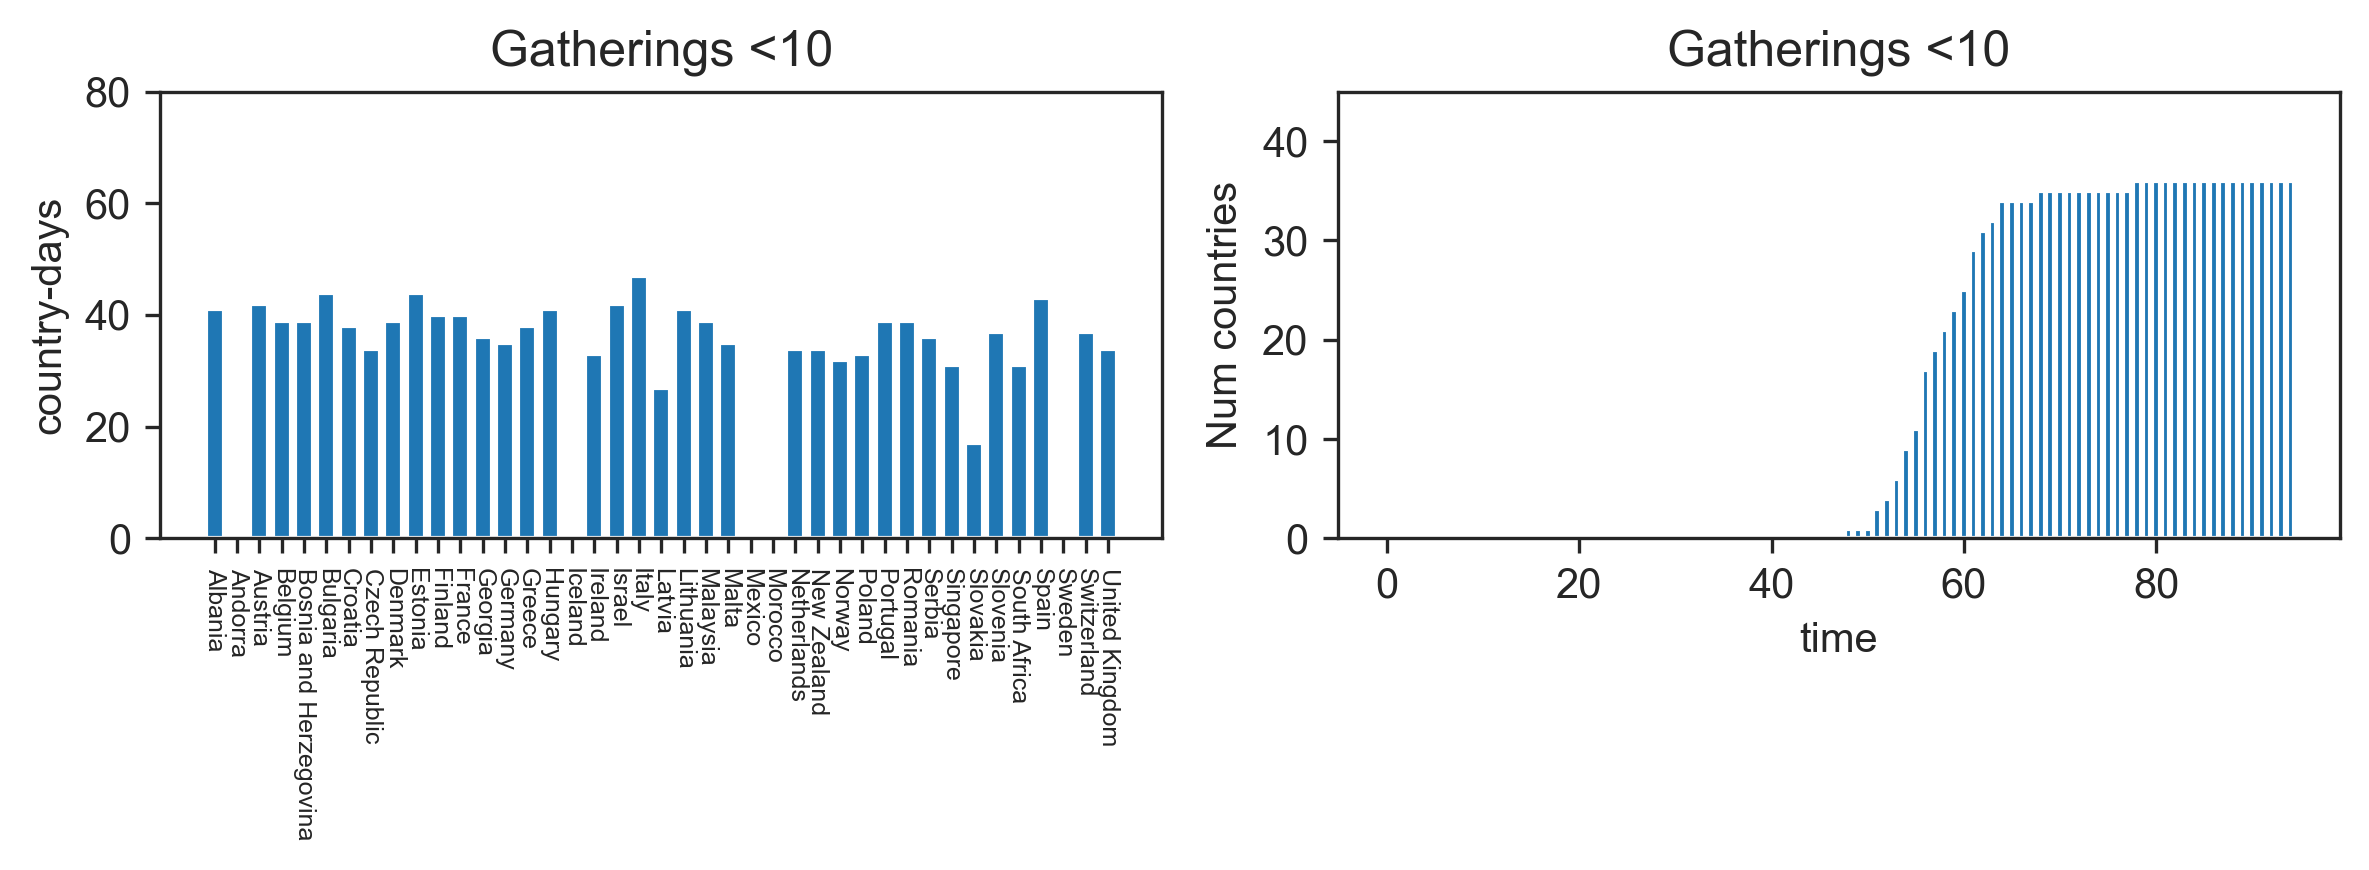

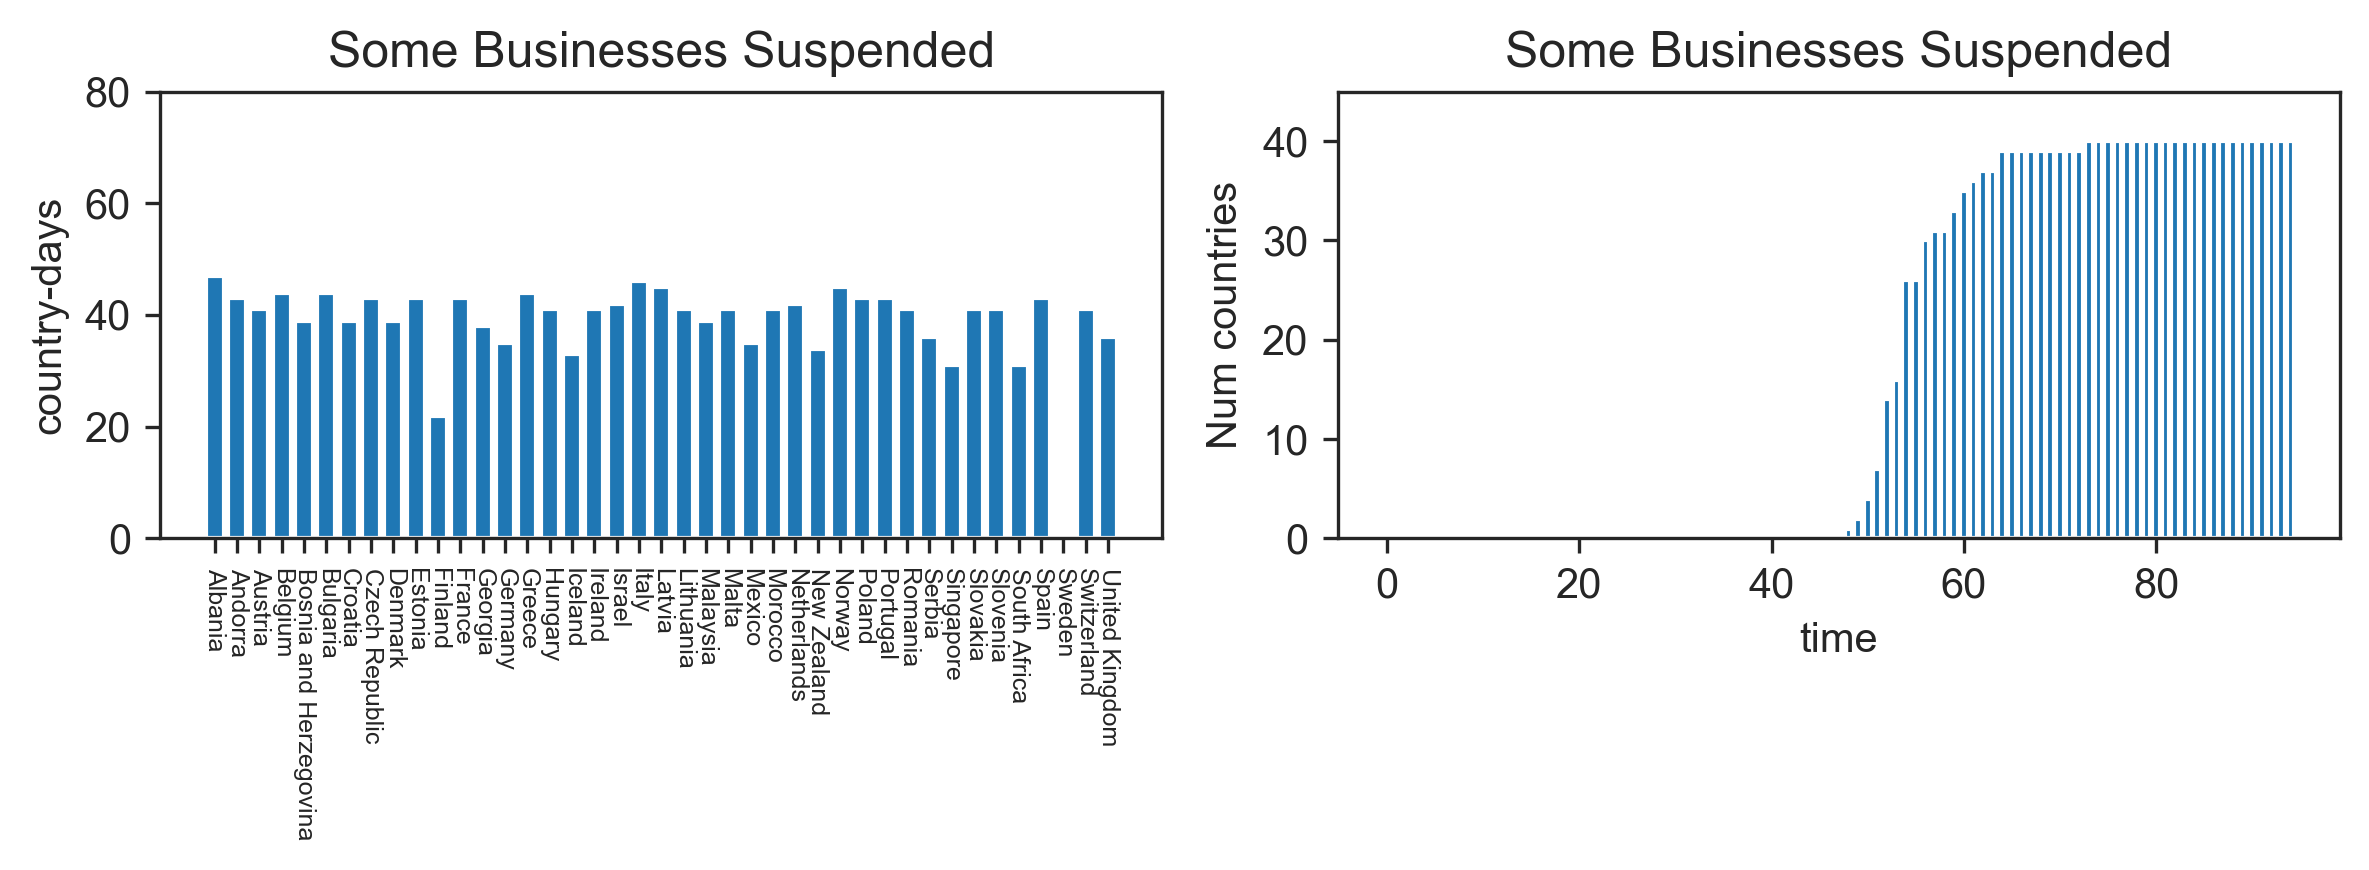

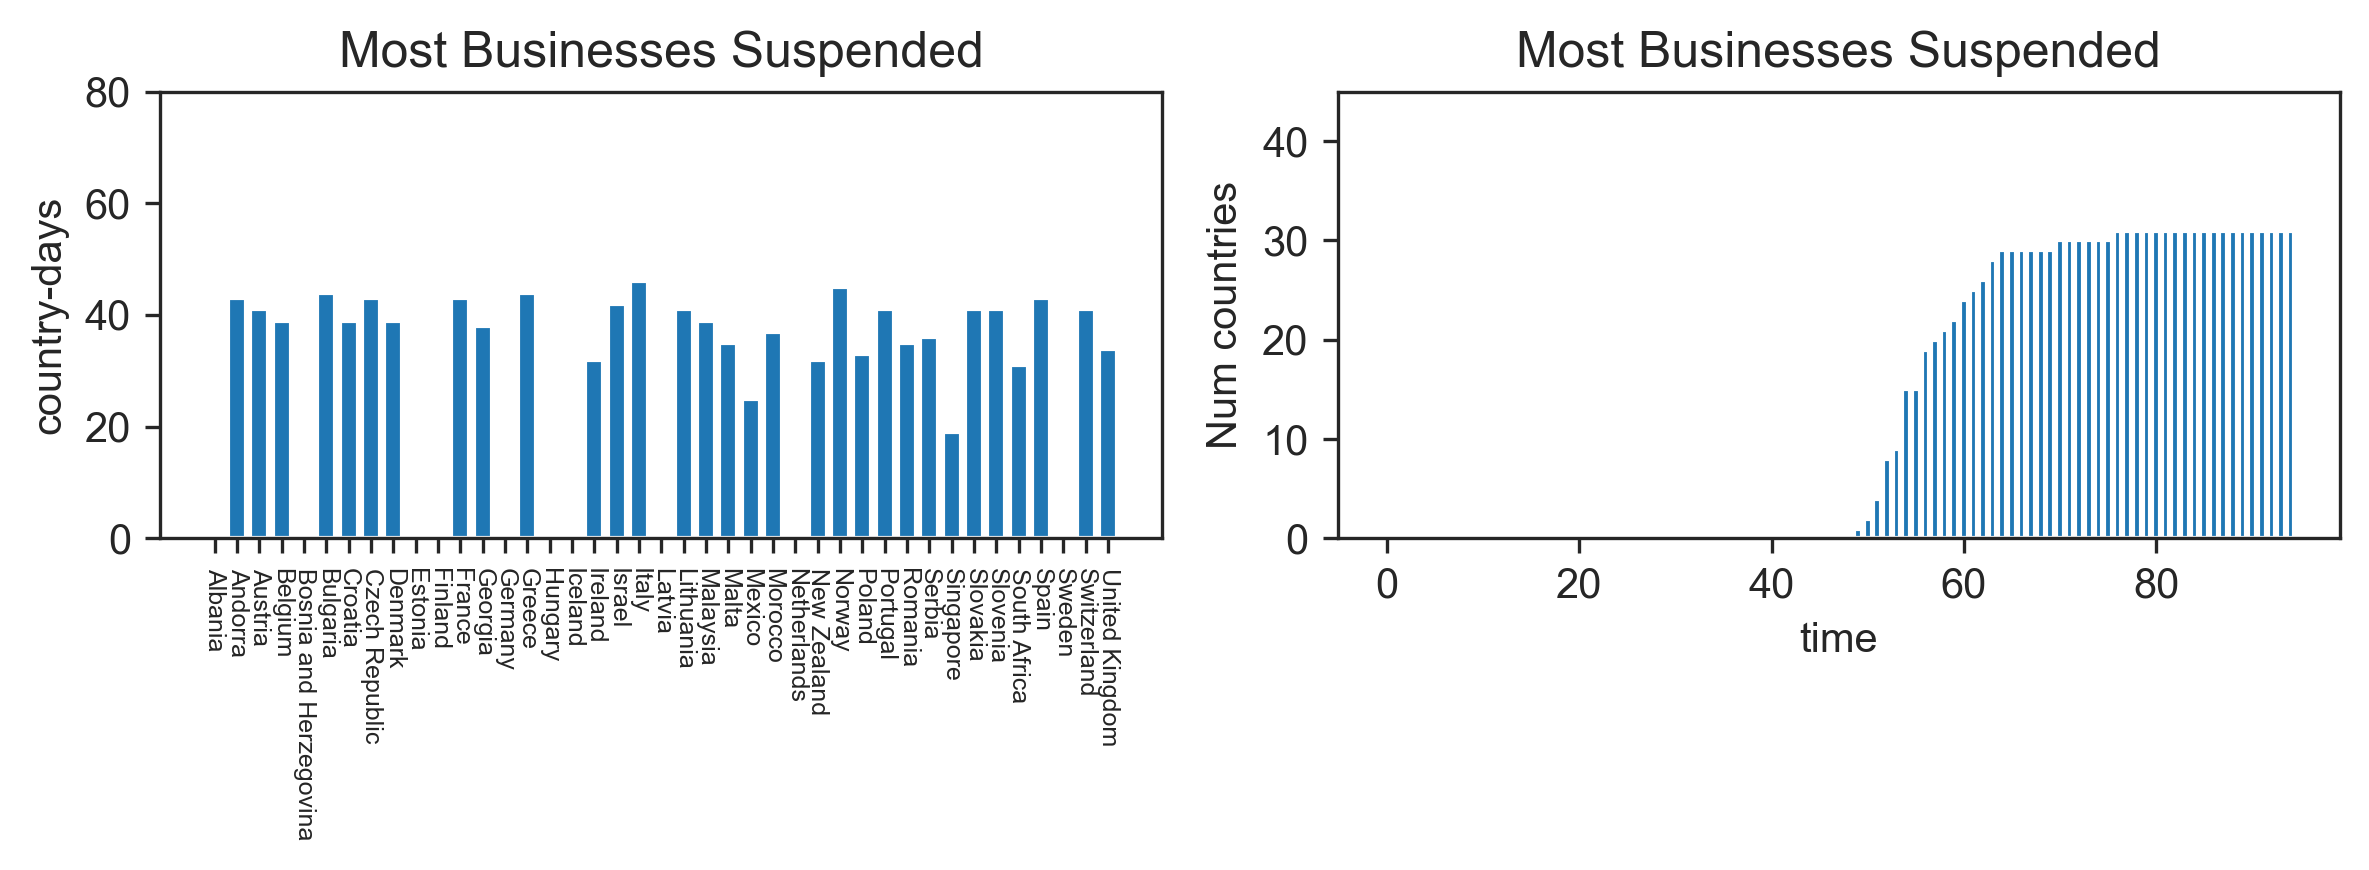

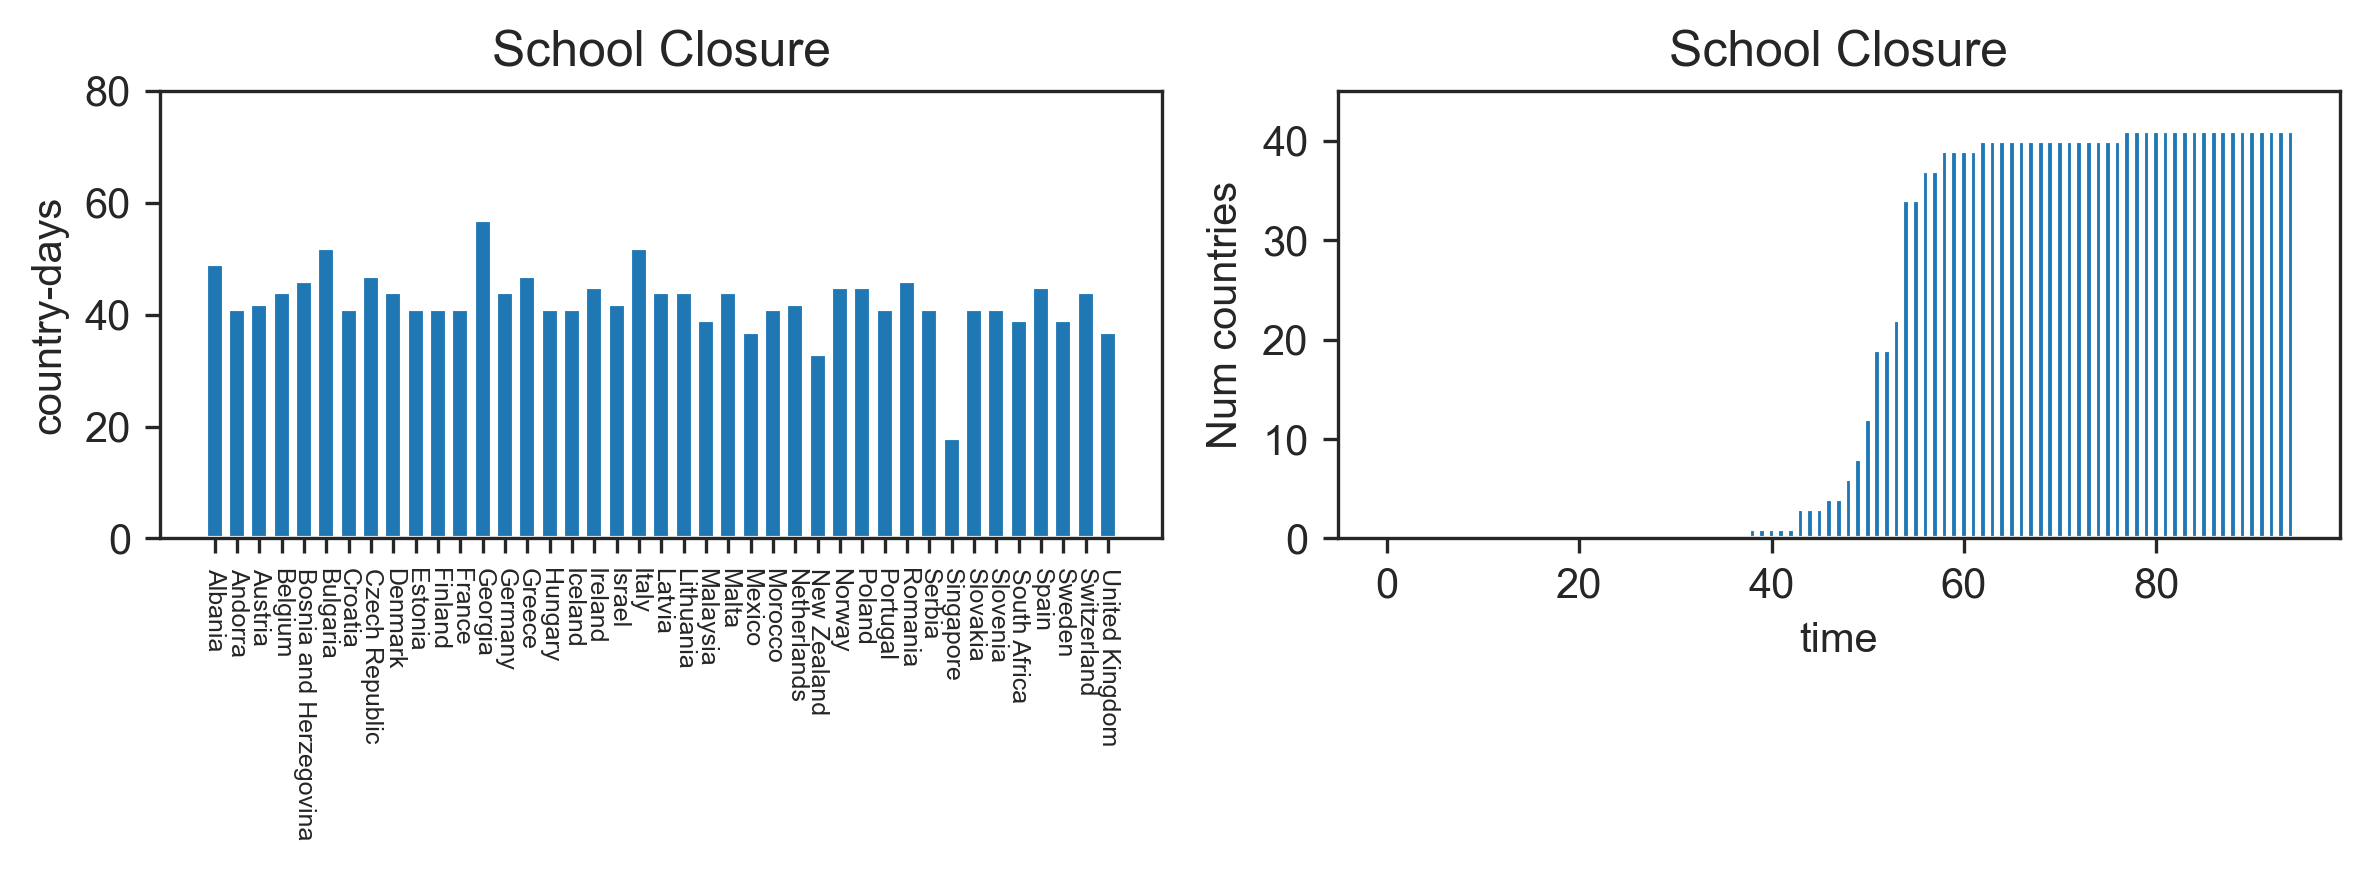

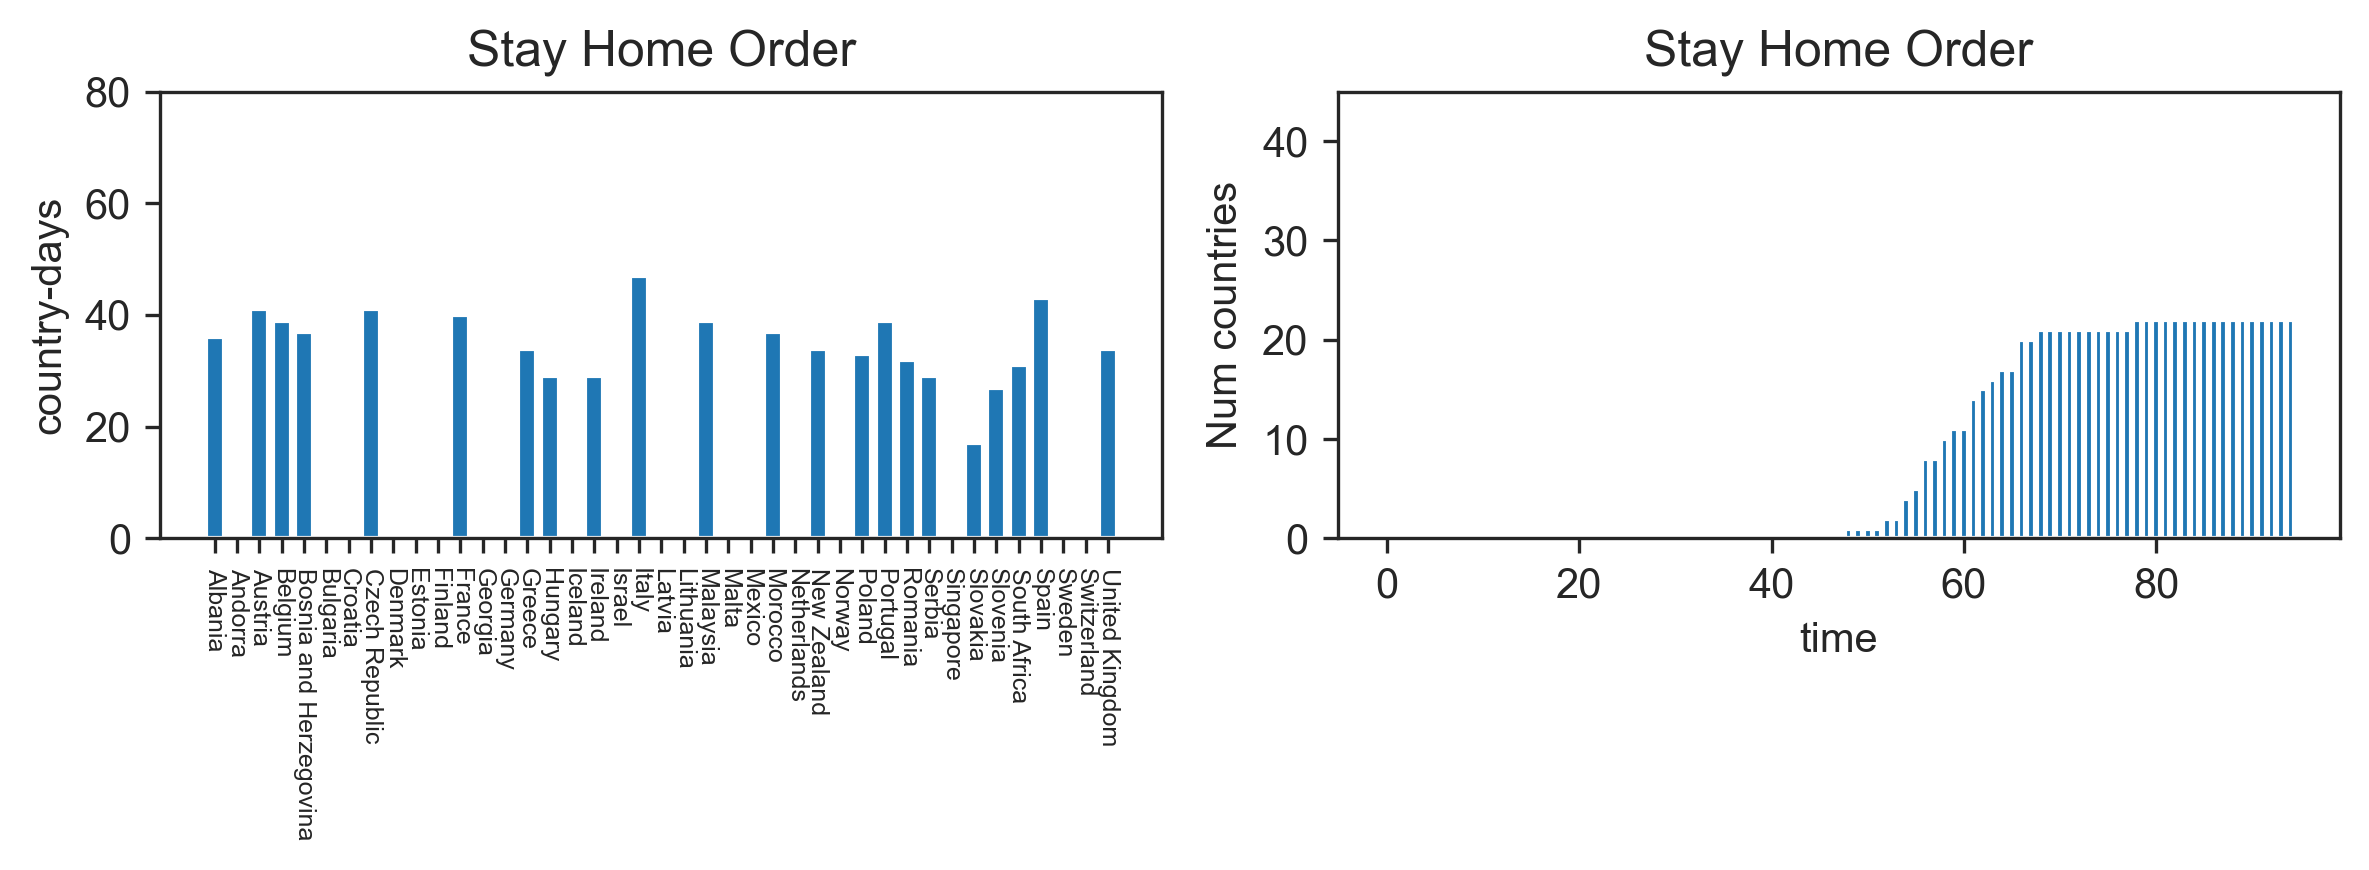

In [36]:
for indx, cm in enumerate(data.CMs):
    hist_data = np.sum(ActiveCMs[:, indx, :], axis=1)
    plt.figure(figsize=(8, 3), dpi=300)
    plt.subplot(121)
    plt.bar(np.arange(len(region_names)), hist_data)
    plt.xticks(np.arange(len(region_names)), region_names, rotation = -90, size=6)
    plt.ylim([0, 80])
    plt.ylabel("country-days")
    plt.title(cm)
    plt.subplot(122)
    hist_data = np.sum(ActiveCMs[:, indx, :], axis=0)
    plt.bar(np.arange(hist_data.size), hist_data)
    plt.title(cm)
    plt.ylim([0, 45])
    plt.ylabel("Num countries")
    plt.xlabel("time")
    plt.tight_layout()

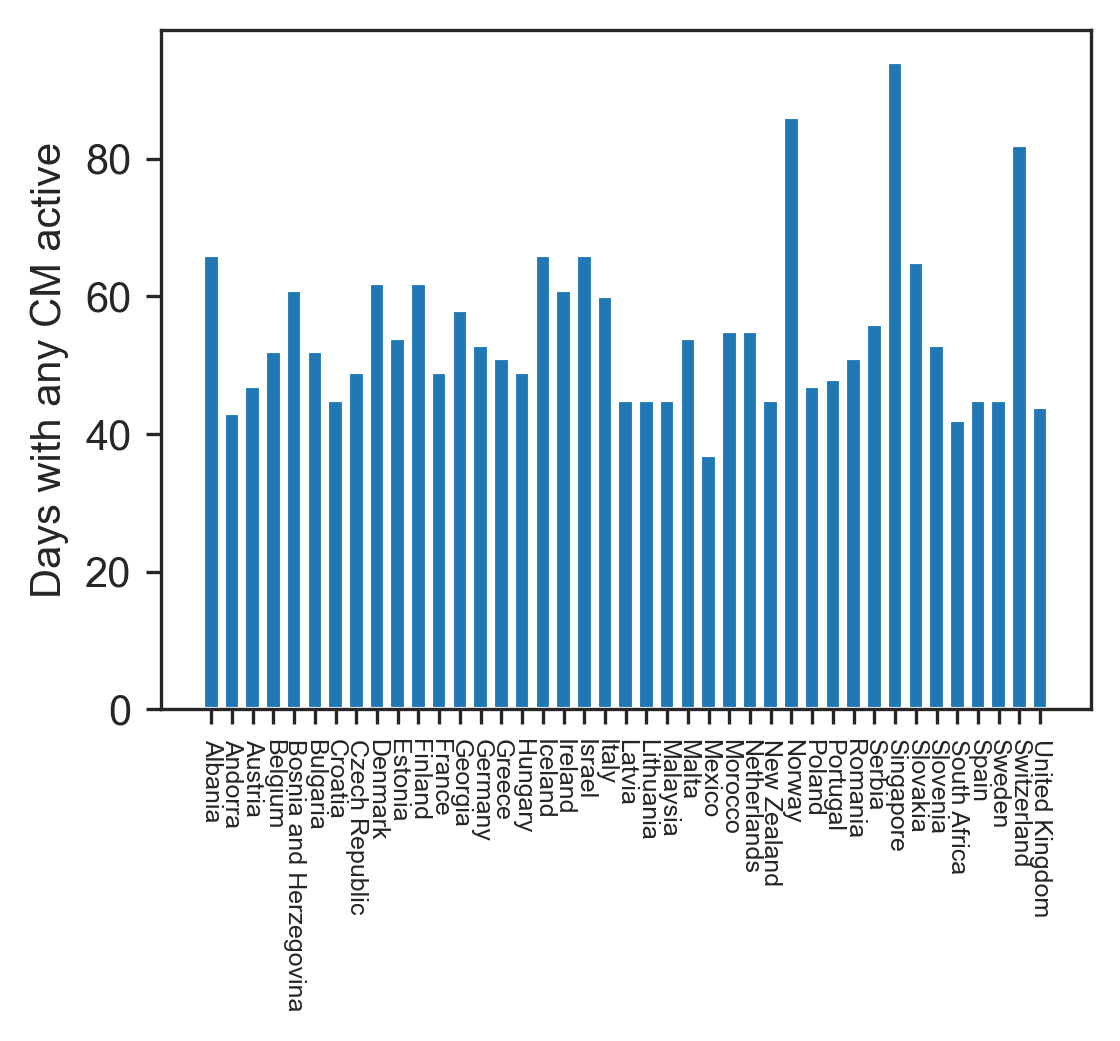

In [37]:
plt.figure(figsize=(4, 3), dpi=300)
cs = np.sum(np.sum(ActiveCMs[:, :, :], axis=1) > 0, axis=-1)
plt.bar(np.arange(len(region_names)), cs)
plt.xticks(np.arange(len(region_names)), region_names, rotation = -90, size=6)
plt.ylabel("Days with any CM active");

In [38]:
data.CMs

['Healthcare Infection Control',
 'Mask Wearing',
 'Symptomatic Testing',
 'Gatherings <1000',
 'Gatherings <100',
 'Gatherings <10',
 'Some Businesses Suspended',
 'Most Businesses Suspended',
 'School Closure',
 'Stay Home Order']

In [39]:
from matplotlib.font_manager import FontProperties
fp2 = FontProperties(fname=r"/Users/mrinank/workspace/fonts/Font Awesome 5 Free-Solid-900.otf")


display_with = [
    [], [], [], [4, 5], 
    [5], [], [7], [], [], []
]


cm_plot_style = [
            ("\uf7f2", "tab:red"), # hospital symbol
            ("\uf963", "black"), # mask
            ("\uf492", "mediumblue"), # vial
            ("\uf0c0", "lightgrey"), # ppl
            ("\uf0c0", "grey"), # ppl
            ("\uf0c0", "black"), # ppl
            ("\uf07a", "tab:orange"), # shop 1
            ("\uf07a", "tab:red"), # shop2 
            ("\uf19d", "black"), # school
            ("\uf965", "black") # home
        ]


In [40]:
for d, f in zip(display_with, data.CMs):
    for i in d:
        print(f"Display {f} with {data.CMs[i]}")

Display Gatherings <1000 with Gatherings <100
Display Gatherings <1000 with Gatherings <10
Display Gatherings <100 with Gatherings <10
Display Some Businesses Suspended with Most Businesses Suspended


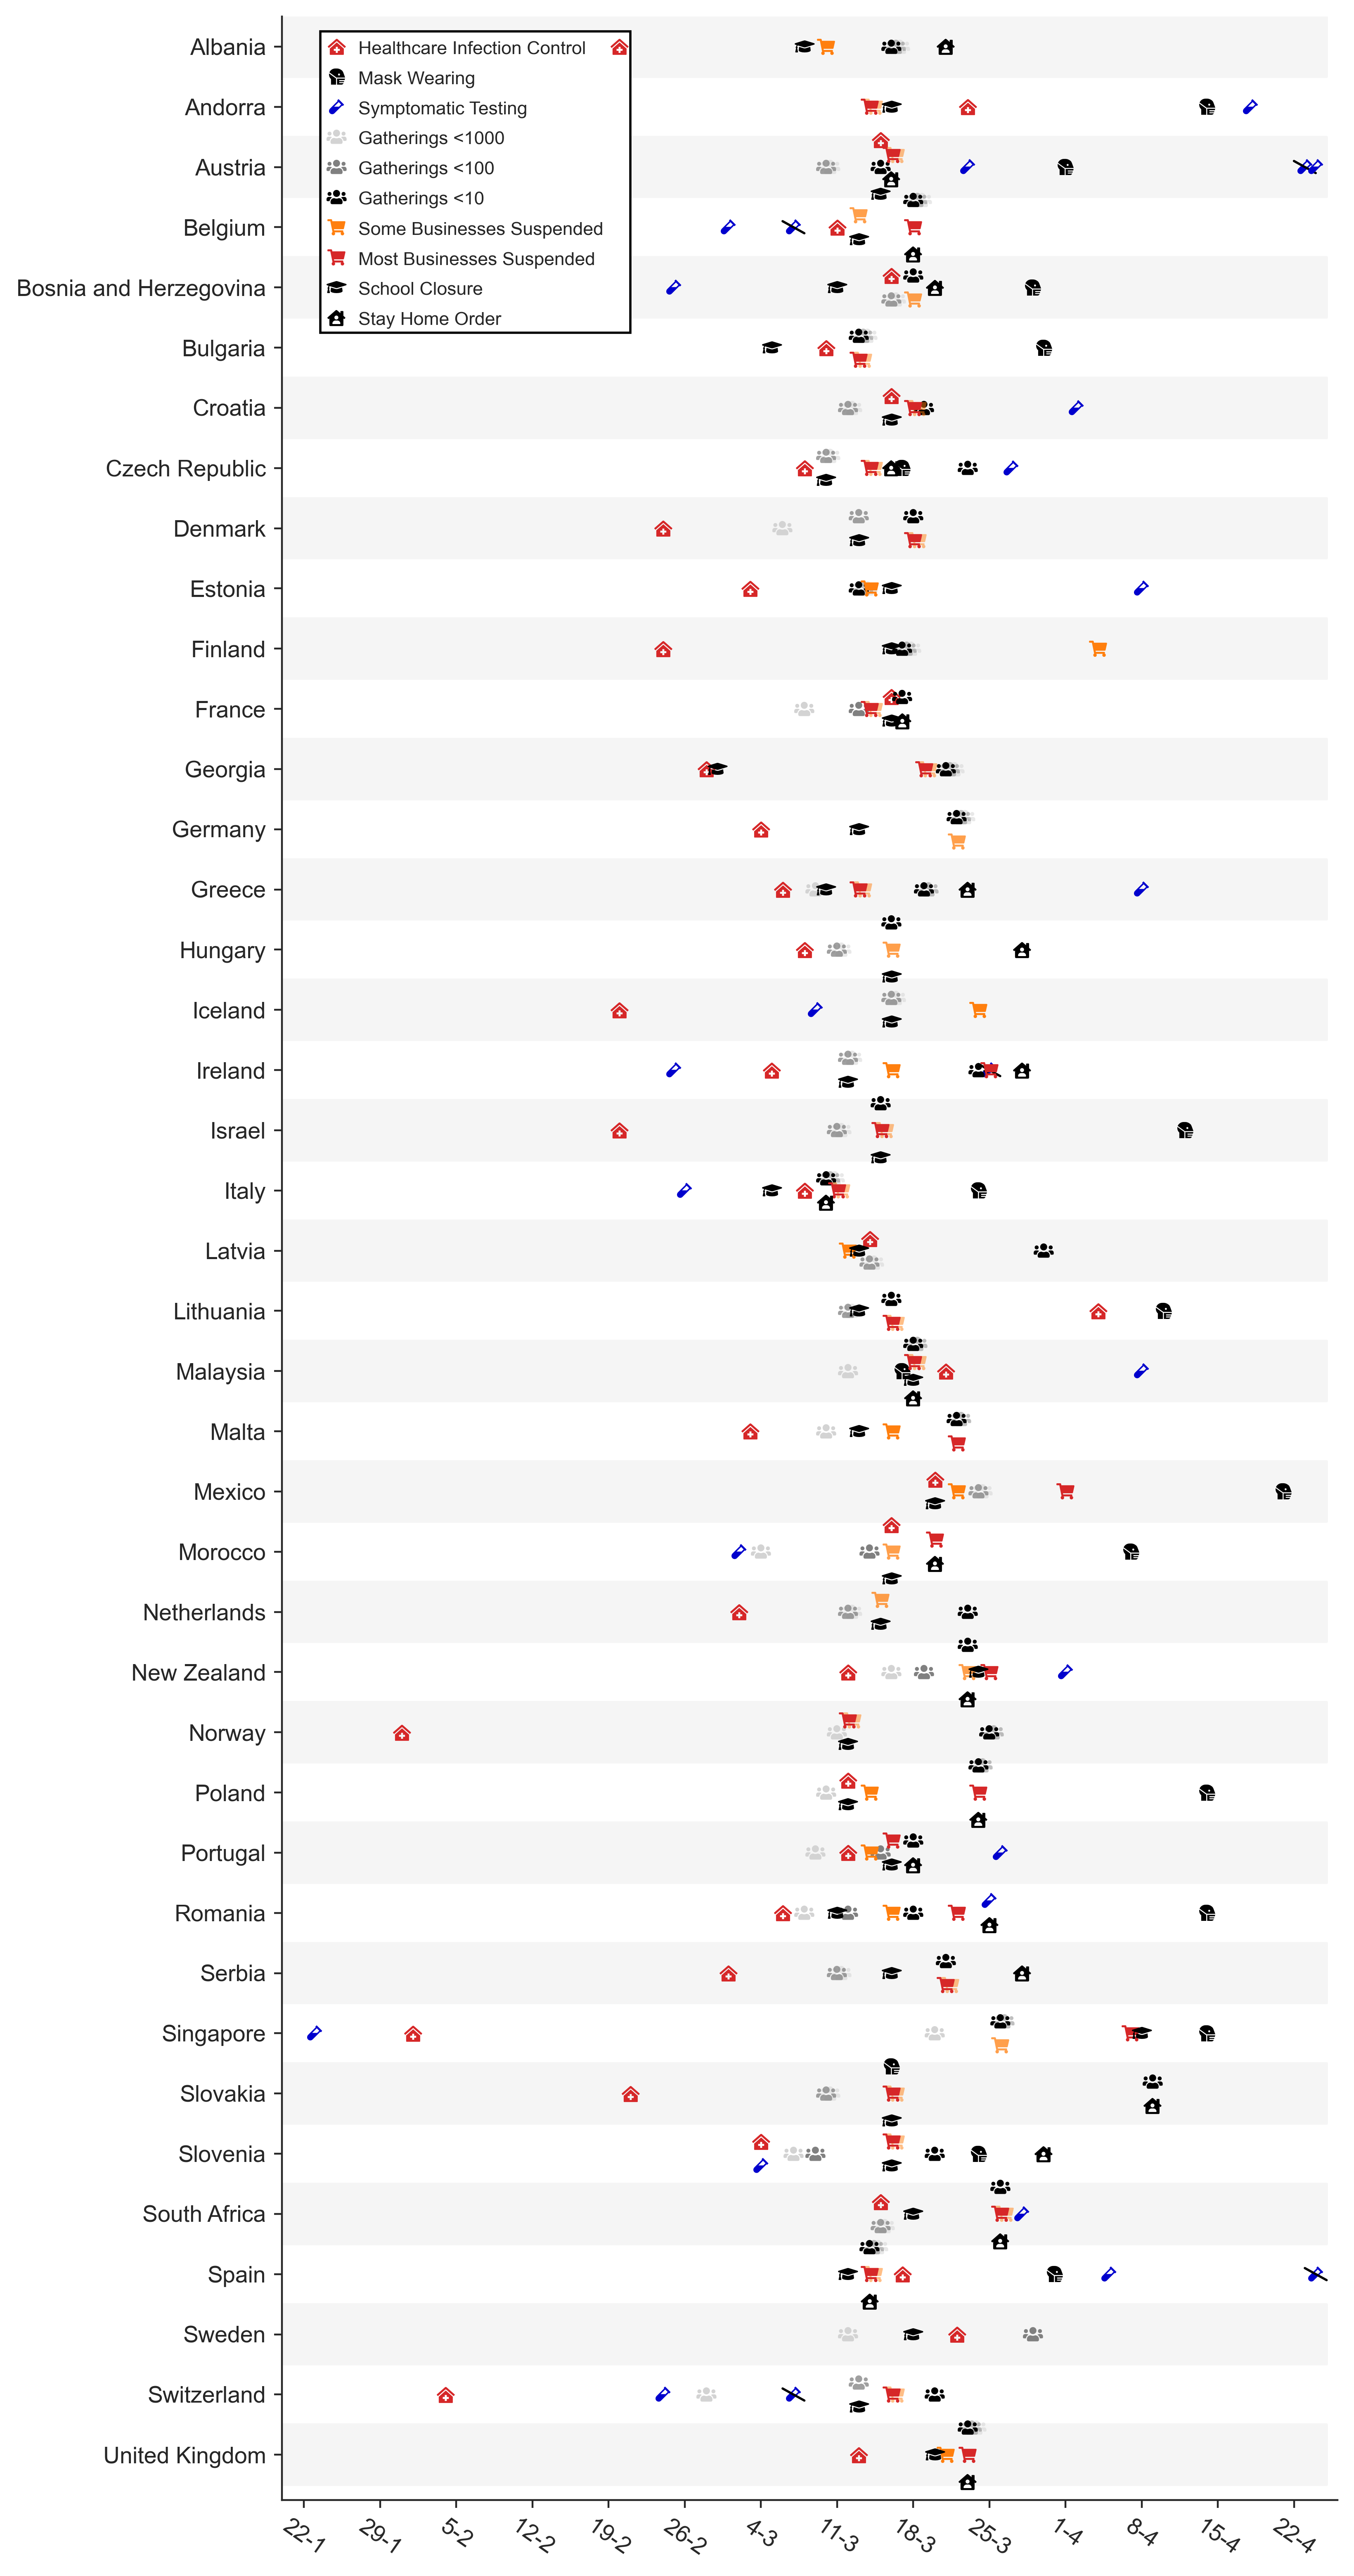

In [41]:
dts = data.Ds
nDs = len(dts)
nRs = len(data.Rs)

x_min = -2
x_max = nDs

spread_small = 0.4
spread_large = 0.9

fig = plt.figure(figsize=(8.3, 15.7), dpi=400)

for height in range(0, nRs, 2):
    plt.fill_between(np.arange(x_min, nDs), -(height-0.5)* np.ones((nDs - x_min)), -(height+0.5)* np.ones((nDs - x_min)), color="whitesmoke")

days_x = np.arange(len(dts))

for d_indx, region in enumerate(region_info):
    all_cm_values = ActiveCMs[d_indx, :, :]
    region_height = -d_indx
    
    a_cm_changes = np.zeros_like(all_cm_values)
    a_cm_changes[:, 1:] = (all_cm_values[:, 1:] - all_cm_values[:, :-1])
    
    all_cm_changes = np.zeros(all_cm_values[0, :].size)
    all_cm_changes[1:] = np.sum((all_cm_values[:, 1:] - all_cm_values[:, :-1])!= 0 , axis=0)
    all_cm_changes[0] = np.sum(all_cm_values[:, 0])
    cum_changes = np.zeros(all_cm_changes.size)
    
    for indx, f in enumerate(data.CMs):
        cm_values = all_cm_values[indx, :]
        cm_changes = np.zeros(cm_values.size)
        cm_changes[1:] = cm_values[1:] - cm_values[:-1]
        cm_changes[0] = 1 if cm_values[0] == 1 else 0
        
        nz = (np.nonzero(cm_changes)[0]).tolist()
        
        for nz_val in nz:
            all_changes = all_cm_changes[nz_val]
            delta_x = 0
            alpha = 1
            height = region_height
                        
            if all_changes > 1:
                effective_changes = 0
                for cm in range(nCMs):
                    if a_cm_changes[cm, nz_val] == 1:
                        if len(display_with[cm]) > 0:
                            for other_display in display_with[cm]:
                                if a_cm_changes[other_display, nz_val] == 1.0:
                                    break
                                else:
                                    effective_changes += 1
                        else:
                            effective_changes += 1

                if effective_changes > 2:
                    spread = spread_large
                else:
                    spread = spread_small
                
                if effective_changes > 1:
                    height = (region_height + spread/2) - ((spread/(effective_changes-1)) * cum_changes[nz_val])
                else:
                    height = region_height
                
                if len(display_with[indx]) > 0:
                    for other_display in display_with[indx]:
                        if a_cm_changes[other_display, nz_val] != 0:
                            delta_x += 0.4
                            alpha = 0.5
                    
                    if a_cm_changes[display_with[indx][0], nz_val] == 0:
                        cum_changes[nz_val] += 1
                        alpha = 0.75
                else:
                    # if display with is empty
                    cum_changes[nz_val] += 1
                
            if cm_changes[nz_val] == 1.0:
                plt.text(nz_val + delta_x, height, cm_plot_style[indx][0], fontproperties=fp2, color=cm_plot_style[indx][1], size=7, alpha=alpha, va="center", ha="center", clip_on=True)
            
            elif cm_changes[nz_val] == -1:
                plt.text(nz_val + delta_x, height,cm_plot_style[indx][0], fontproperties=fp2,  color=cm_plot_style[indx][1], size=7, alpha=alpha, va="center", ha="center", clip_on=True, zorder=1)
                plt.plot([nz_val-1, nz_val+1], [height+0.1, height-0.1], linewidth=1, color="black", zorder=2)
            
            else:
                print(f"Something weird Region {region[0]} NPI: {f} {cm_changes[nz_val-1]}")
        
locs = np.arange(0, nDs, 7)
xlabels = [f"{dts[ts].day}-{dts[ts].month}" for ts in locs]

import matplotlib.patches as patches

rect = patches.Rectangle((x_min + 3.5, -0.5*nCMs + 0.25), 28.5, 0.5*nCMs , linewidth=1, edgecolor="black", facecolor="white")
plt.gca().add_patch(rect)
for indx, f in enumerate(data.CMs):
    plt.text(x_min + 5, -0.5*indx , cm_plot_style[indx][0], fontproperties=fp2,  color=cm_plot_style[indx][1], size=7, va="center", ha="center", clip_on=True, zorder=1)
    plt.text(x_min + 7, -0.5*indx - 0.05, f, size=8, va="center", ha="left")

plt.xticks(locs, xlabels, rotation=-35)
plt.xlim([x_min, x_max])
plt.yticks(-np.arange(len(region_names)), region_names)
plt.ylim([-nRs+0.25, 0.5])
sns.despine()
plt.tight_layout()
plt.savefig("time.pdf")